In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
# import tensorflow_decision_forests as tfdf
import seaborn as sns
import math
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from xgboost import XGBClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.feature_selection import RFE
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_selection import mutual_info_classif
from skfeature.function.similarity_based import fisher_score

2024-10-12 12:30:20.851493: I external/local_tsl/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-10-12 12:30:20.971328: I external/local_tsl/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-10-12 12:30:21.037217: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:479] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-10-12 12:30:21.154906: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:10575] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-10-12 12:30:21.154960: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1442] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-10-12 12:30:21.282168: I tensorflow/core/platform/cpu_feature_guard.cc:

In [2]:
# master_dataset = pd.read_csv('CreatingDataset/ppmi_master_dataset.csv')

In [3]:
# master_dataset.head()

In [4]:
# master_dataset.isnull().sum()

In [5]:
# master_dataset = master_dataset.ffill()

In [6]:
# master_dataset.isnull().sum()

In [7]:
# master_dataset.to_csv('CreatingDataset/no_missing_value_ppmi_master_dataset.csv', index=False)

In [8]:
master_dataset = pd.read_csv('/home/zagreus/Programming/PPMI_Research_on_Parkinsons/src/Sadi/CreatingDataset/WorkingCSVs_DONT_DELETE/finalDatasetWithUPDRSScore.csv')

In [9]:
master_dataset.head()

,Patient ID,Visit Date,Area,Circularity,ConvexArea,EquivDiameter,Extent,FilledArea,Kurtosis,Major axis length,...,DATSCAN_CAUDATE_R,DATSCAN_CAUDATE_L,DATSCAN_PUTAMEN_R,DATSCAN_PUTAMEN_L,DATSCAN_PUTAMEN_R_ANT,DATSCAN_PUTAMEN_L_ANT,UPDRS_SCORE,Disease_Severity,Visit,Visit_int
0,3010,2011-07,389.666667,0.347044,537.333333,21.855180,0.552101,393.333333,124.787788,27.661910,...,2.86,3.65,0.45,1.24,1.50,2.35,41,Moderate,V1,0
1,3010,2012-06,1242.000000,0.232069,1594.333333,39.709426,0.603968,1248.000000,52.422599,44.351253,...,1.93,2.60,0.53,0.78,1.03,1.61,58,Moderate to Severe,V2,11
2,3010,2013-07,887.000000,0.521797,1025.000000,33.604811,0.747054,888.333333,78.186385,36.053962,...,1.60,2.50,0.30,0.74,0.85,1.43,67,Severe,V3,24
3,3010,2015-06,737.333333,0.175688,922.000000,25.498446,0.560028,739.666667,63.755847,30.316400,...,1.51,1.92,0.44,0.54,0.76,1.02,47,Moderate,V4,47
4,3012,2011-10,862.333333,0.378363,1050.333333,33.124654,0.613324,863.333333,70.920120,39.665361,...,2.09,2.05,0.36,0.71,1.10,0.98,48,Moderate to Severe,V1,0


In [10]:
# # Convert Visit Date to datetime format
# master_dataset['Visit Date'] = pd.to_datetime(master_dataset['Visit Date'], format='%d/%m/%Y')
# 
# # Group by Patient ID, Visit Date, and EVENT_ID
# grouped_master_dataset = master_dataset.groupby(['Patient ID', 'Visit Date', 'EVENT_ID']).sum().reset_index()

In [11]:
# grouped_master_dataset.to_csv('CreatingDataset/grouped_no_missing_value_ppmi_master_dataset.csv', index=False)

In [12]:
# grouped_master_dataset

In [13]:
# unique_patients = grouped_master_dataset['Patient ID'].nunique()
# print(unique_patients)

In [16]:
# Load the dataset
master_dataset = pd.read_csv('CreatingDataset/no_missing_value_ppmi_master_dataset.csv')

# Convert Visit Date to datetime format
master_dataset['Visit Date'] = pd.to_datetime(master_dataset['Visit Date'], format='%d/%m/%Y')

# Group by Patient ID, Visit Date, and EVENT_ID (sum is not necessary if there are no numeric columns to aggregate)
grouped_master_dataset = master_dataset.groupby(['Patient ID', 'Visit Date', 'EVENT_ID']).first().reset_index()

# Calculate the first visit date for each patient
grouped_master_dataset['first_visit_date'] = grouped_master_dataset.groupby('Patient ID')['Visit Date'].transform('min')

# Calculate the interval in months from the first visit date
grouped_master_dataset['month_interval'] = grouped_master_dataset.apply(
    lambda row: (row['Visit Date'].year - row['first_visit_date'].year) * 12 + (row['Visit Date'].month - row['first_visit_date'].month),
    axis=1
)

# Drop the first_visit_date column if it's not needed
grouped_master_dataset = grouped_master_dataset.drop(columns=['first_visit_date'])

# Reorder columns to place month_interval next to Visit Date
cols = list(grouped_master_dataset.columns)
visit_date_index = cols.index('Visit Date')
# Move month_interval to the position after Visit Date
cols.insert(visit_date_index + 1, cols.pop(cols.index('month_interval')))
grouped_master_dataset = grouped_master_dataset[cols]

In [71]:
grouped_master_dataset_interval = grouped_master_dataset.to_csv('CreatingDataset/no_missing_value_ppmi_master_dataset_interval.csv')

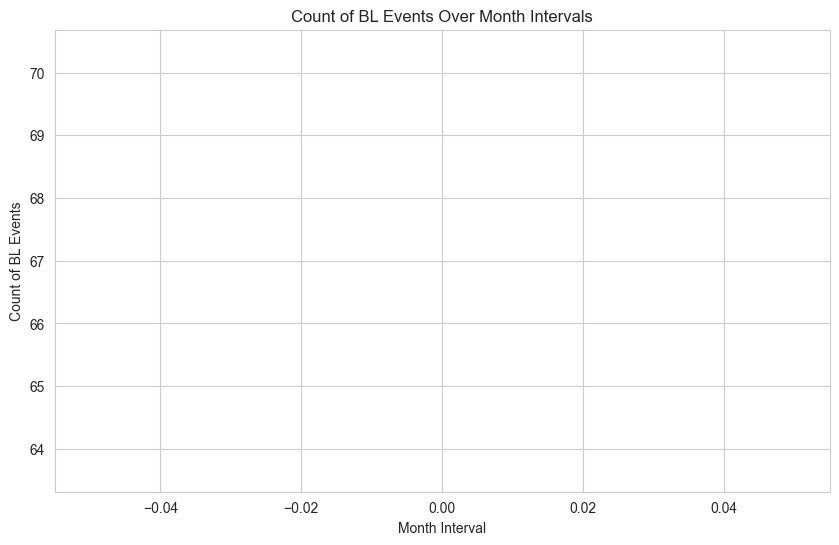

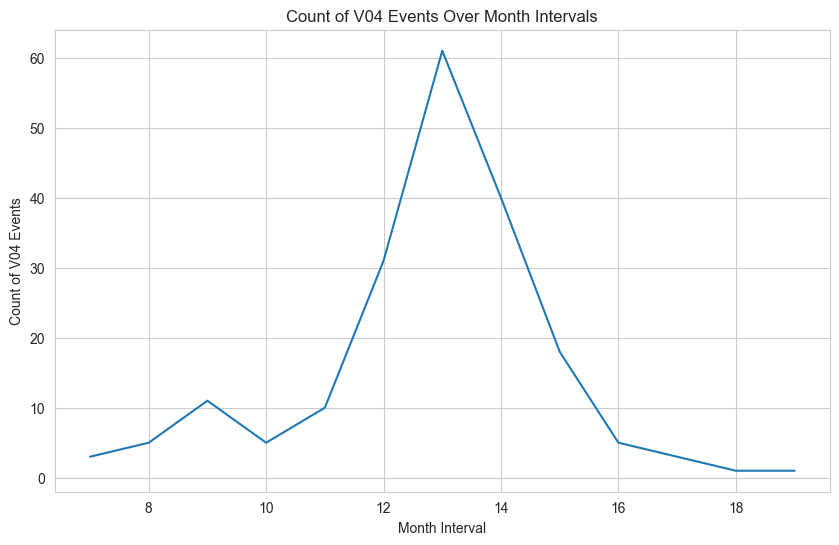

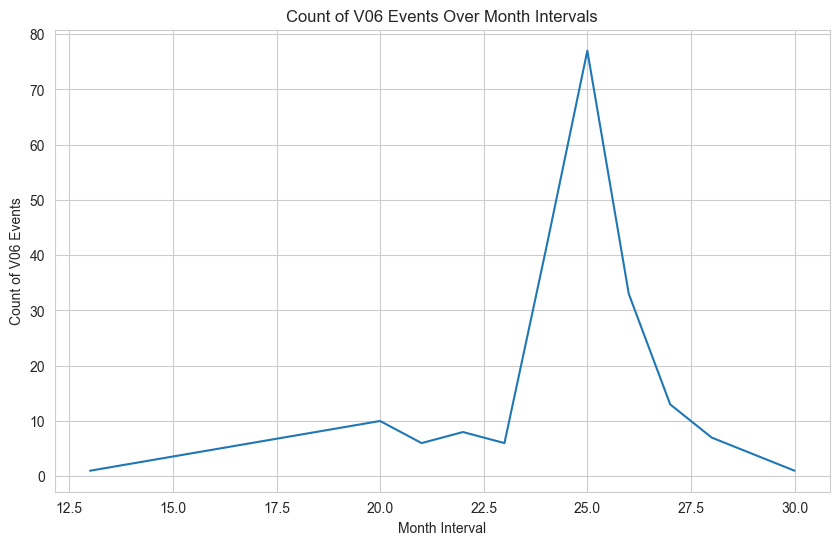

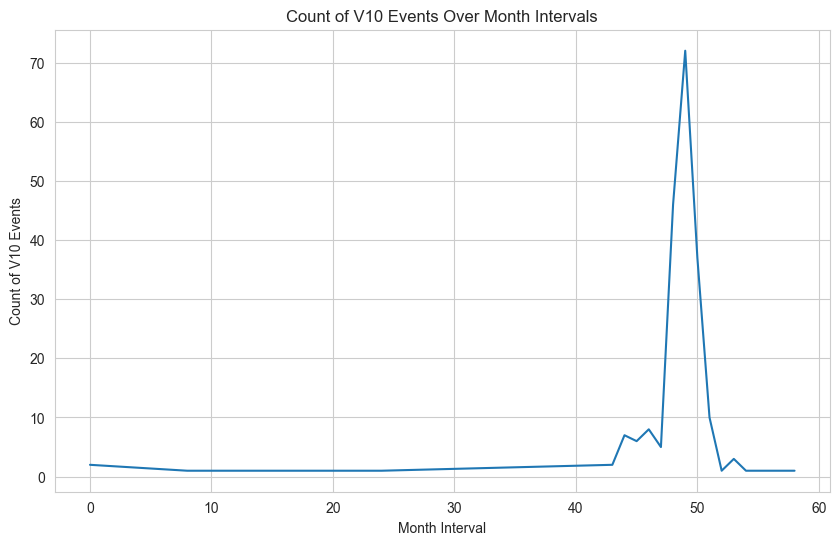

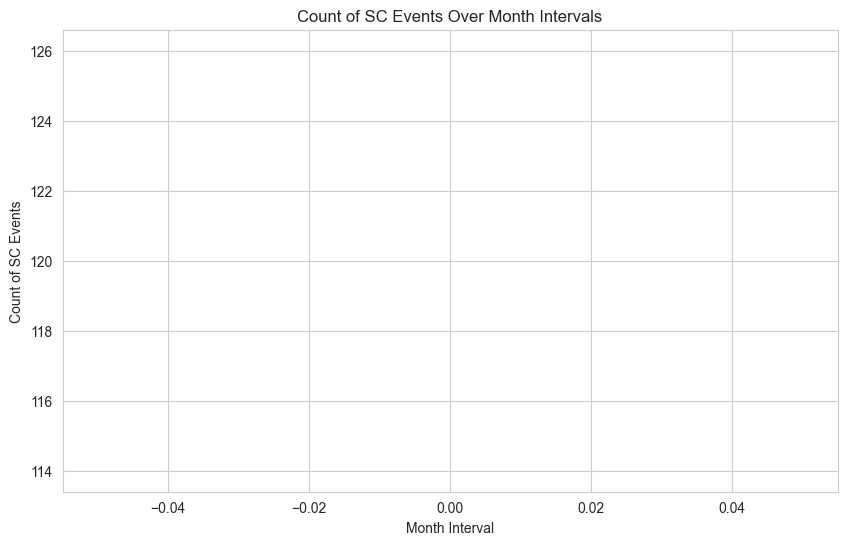

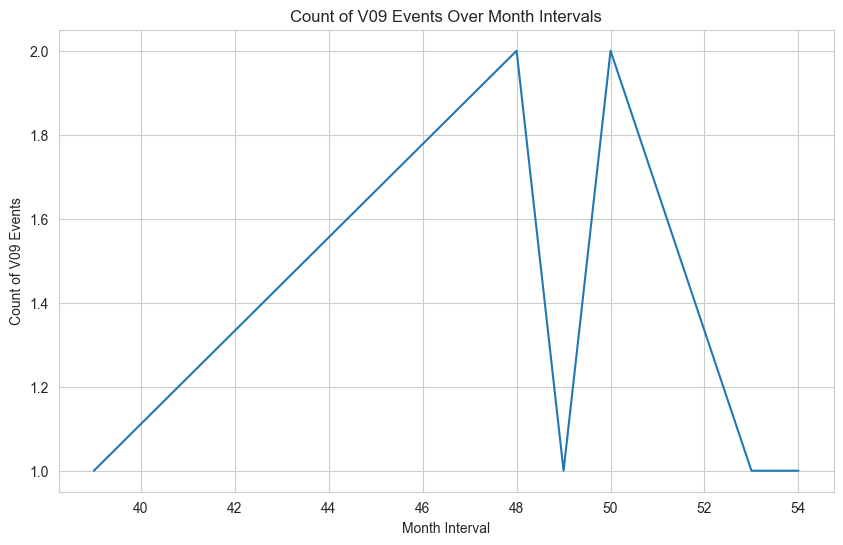

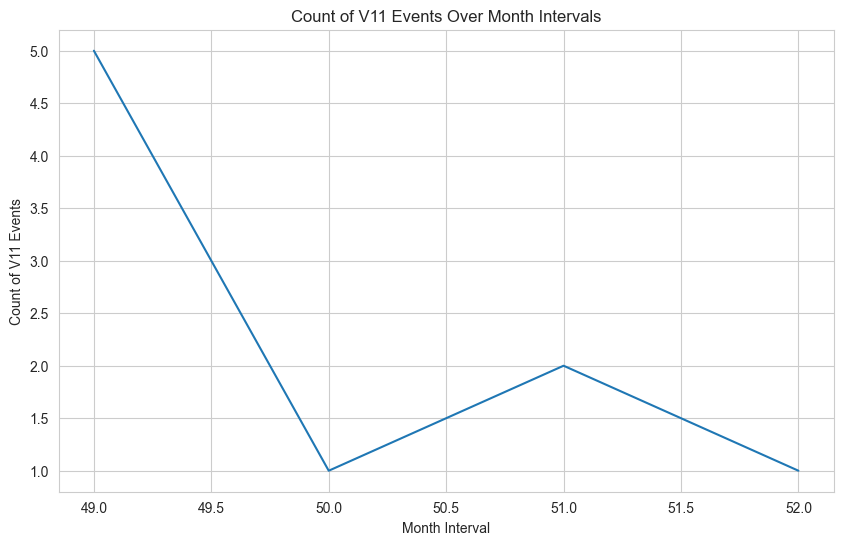

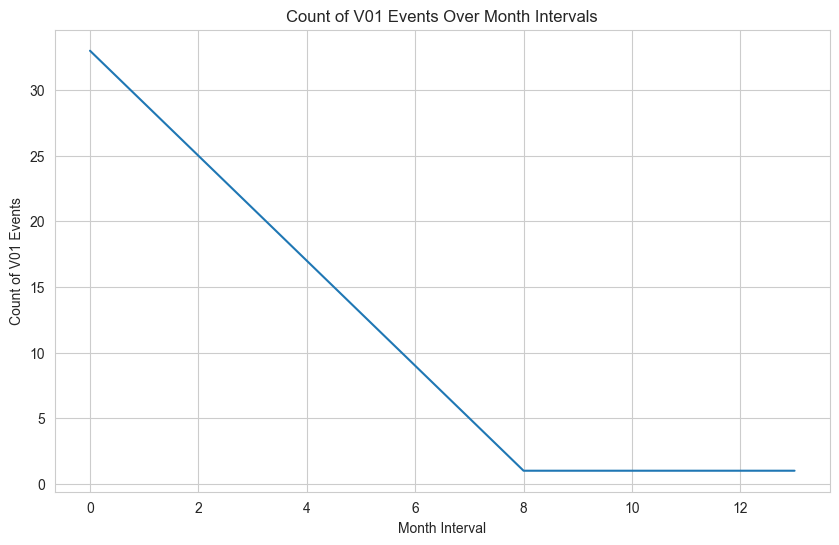

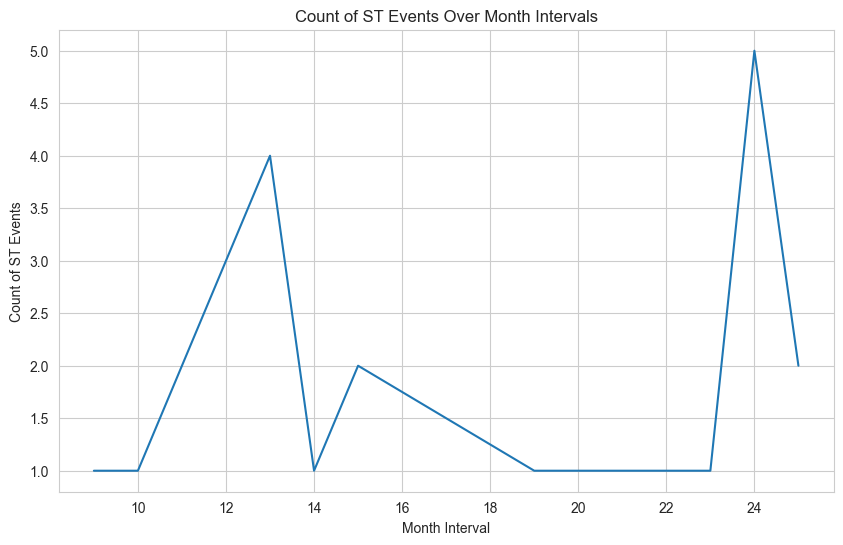

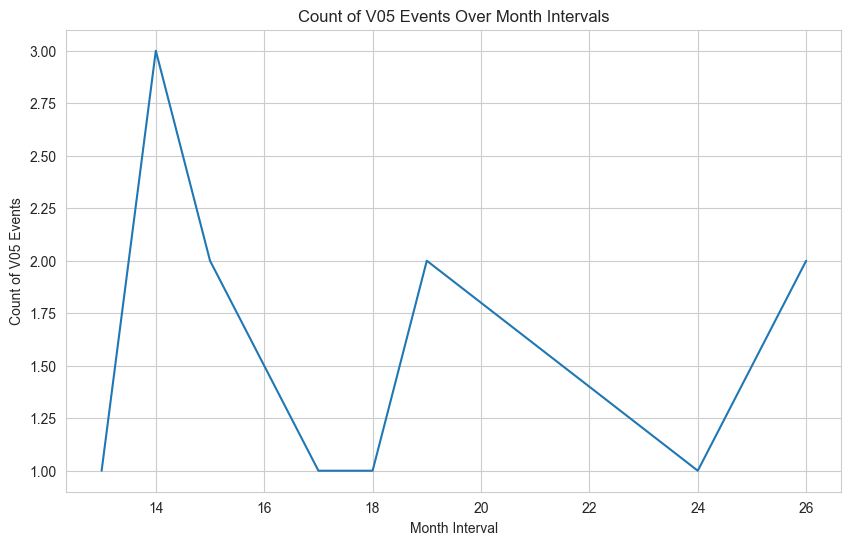

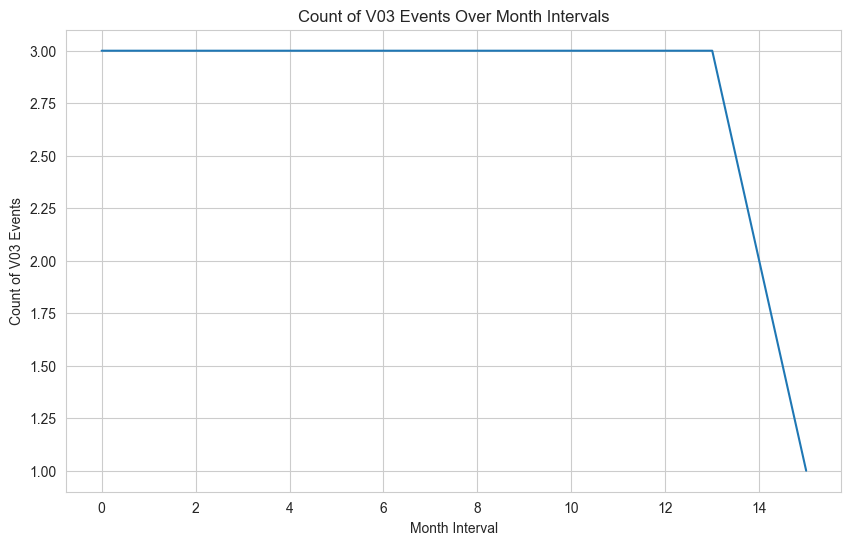

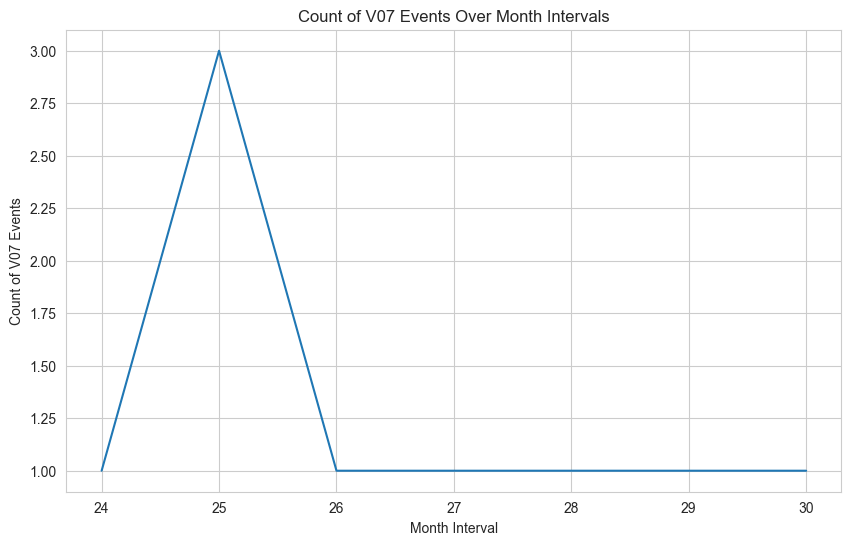

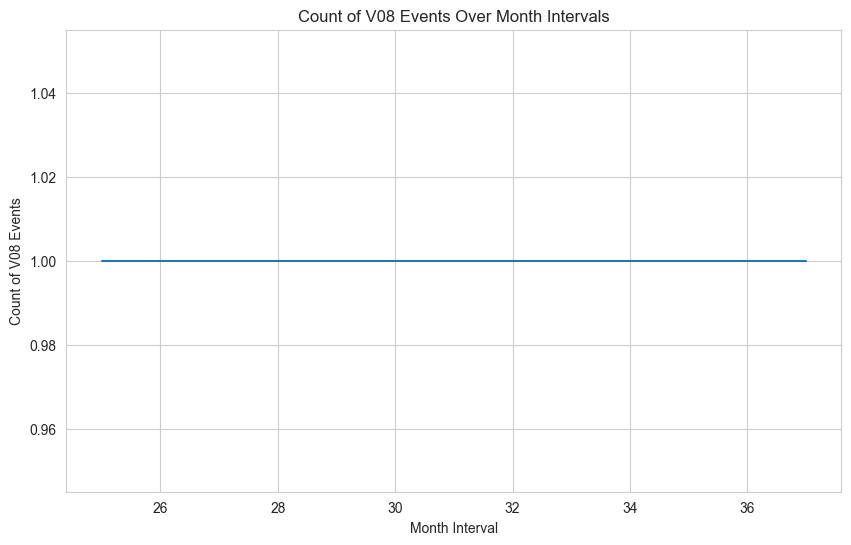

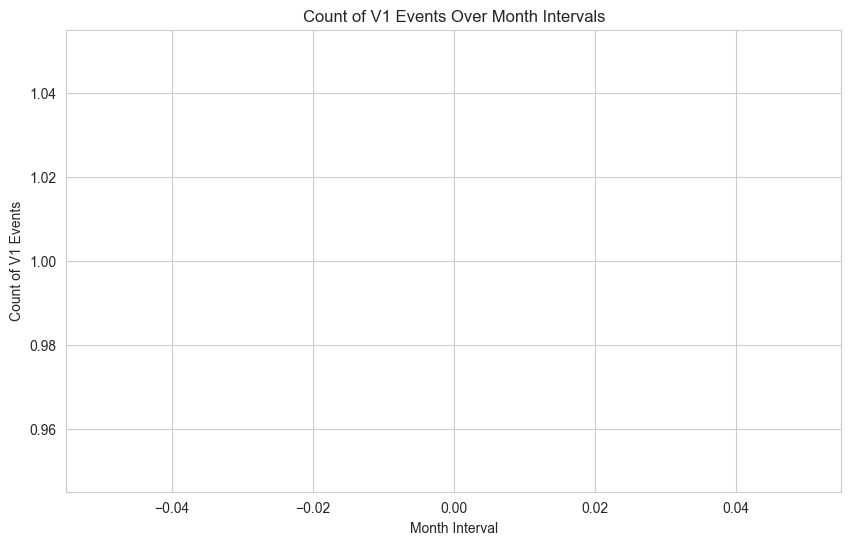

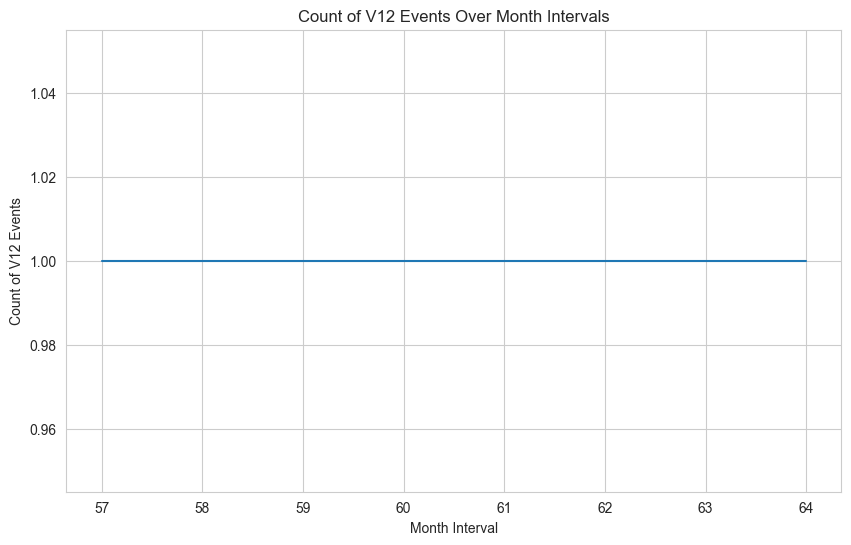

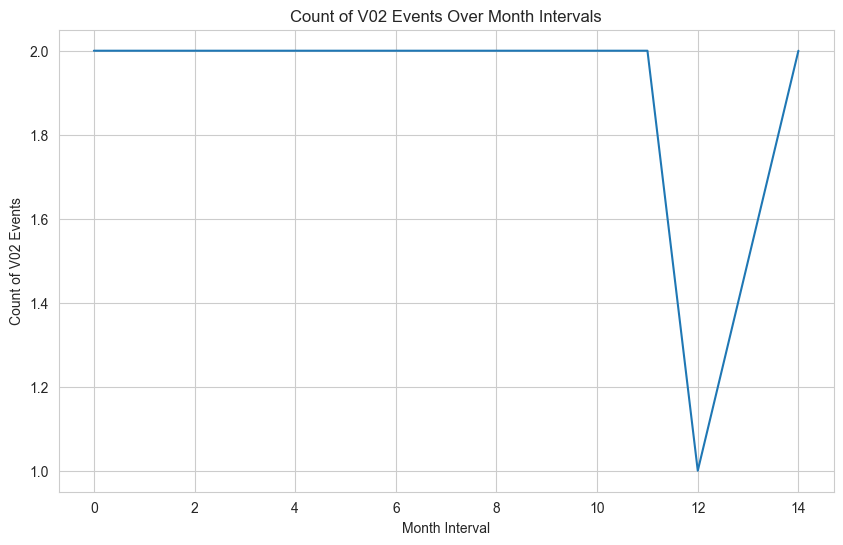

In [62]:
# Get all unique EVENT_IDs
unique_event_ids = grouped_master_dataset['EVENT_ID'].unique()

for event_id in unique_event_ids:
    # Filter the DataFrame
    event_data = grouped_master_dataset[grouped_master_dataset['EVENT_ID'] == event_id]

    # Count the number of current EVENT_ID events for each 'month_interval'
    event_counts = event_data['month_interval'].value_counts().sort_index()

    # Create the plot
    plt.figure(figsize=(10, 6))  # Optional: Adjust the size of the plot
    plt.plot(event_counts.index, event_counts.values)

    # Add labels and title
    plt.xlabel('Month Interval')
    plt.ylabel(f'Count of {event_id} Events')
    plt.title(f'Count of {event_id} Events Over Month Intervals')

    # Display the plot
    plt.show()

In [19]:
# modes = grouped_master_dataset['month_interval'].value_counts().nlargest(4)
# print(modes)

In [20]:
# bins = range(0, grouped_master_dataset['month_interval'].max() + 10, 10)
# grouped_master_dataset['month_interval_range'] = pd.cut(grouped_master_dataset['month_interval'], bins)

In [21]:
# modes = grouped_master_dataset['month_interval_range'].value_counts().nlargest(4)
# print(modes)

In [22]:
# Define a function to classify the visit
def classify_visit(month_interval):
    if 0 <= month_interval <= 7:
        return 'First Visit'
    elif 8 <= month_interval <= 18:
        return 'Second Visit'
    elif 19 <= month_interval <= 29:
        return 'Third Visit'
    else:
        return 'Fourth Visit'

# Create the visit_class column
grouped_master_dataset['Visit_Class'] = grouped_master_dataset['month_interval'].apply(classify_visit)

# # Display the result
# print(grouped_master_dataset)

In [24]:
# Get the list of column names
cols = list(grouped_master_dataset.columns)

# Find the current index of 'month_interval' and 'Visit_Class'
month_interval_index = cols.index('month_interval')
visit_class_index = cols.index('Visit_Class')

# Remove 'Visit_Class' from its current position
cols.pop(visit_class_index)

# Insert 'Visit_Class' after 'month_interval'
cols.insert(month_interval_index + 1, 'Visit_Class')

# Reorder the DataFrame
grouped_master_dataset = grouped_master_dataset[cols]

In [25]:
grouped_master_dataset

,Patient ID,Visit Date,month_interval,Visit_Class,EVENT_ID,NP3SPCH,NP3FACXP,NP3RIGN,NP3RIGRU,NP3RIGLU,...,brightness,contrast,correlation,dissimilarity,energy,gabor_energy,gabor_entropy,homogeneity,lbp_energy,lbp_entropy
0,3010,2011-07-13,0,First Visit,BL,0.0,1.0,1.0,0.0,2.0,...,0.007926,158.463741,0.831520,0.816963,0.989929,9.525620,379.868298,0.995363,0.990573,0.054468
1,3010,2012-06-26,11,Second Visit,V04,1.0,2.0,1.0,0.0,2.0,...,0.018020,326.583983,0.852982,1.562270,0.977459,17.621092,781.401212,0.991459,0.983486,0.089167
2,3010,2013-07-17,24,Third Visit,V06,2.0,2.0,1.0,0.0,2.0,...,0.012063,178.744707,0.882104,0.894156,0.985684,13.268292,519.371246,0.994178,0.988597,0.064722
3,3010,2015-06-26,47,Fourth Visit,V10,1.0,2.0,0.0,0.0,2.0,...,0.014601,296.968707,0.837949,1.390070,0.982016,16.052184,658.612867,0.992227,0.984798,0.082195
4,3012,2011-10-11,0,First Visit,SC,0.0,2.0,0.0,1.0,0.0,...,0.013327,167.855630,0.899377,0.768224,0.984650,15.227890,573.424163,0.996028,0.990869,0.053686
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
907,137450,2024-03-19,27,Third Visit,V06,1.0,2.0,1.0,2.0,2.0,...,0.018947,720.422511,0.685260,3.253121,0.972526,20.735130,945.195488,0.982511,0.972334,0.133635
908,142004,2022-02-24,0,First Visit,BL,1.0,1.0,0.0,2.0,2.0,...,0.015122,209.292168,0.890132,1.108192,0.981616,15.682664,664.117954,0.992613,0.986875,0.073646
909,142004,2022-11-07,9,Second Visit,V02,1.0,2.0,2.0,2.0,3.0,...,0.015591,521.905040,0.711337,2.744637,0.972261,15.482913,804.136152,0.979712,0.970353,0.142520
910,142004,2023-04-03,14,Second Visit,V04,0.0,1.0,1.0,1.0,2.0,...,0.017739,190.860029,0.910562,0.914200,0.979811,17.088529,712.152217,0.994828,0.988797,0.063939


In [70]:
grouped_master_dataset.dtypes

Patient ID                 int64
Visit Date        datetime64[ns]
month_interval             int64
Visit_Class               object
EVENT_ID                  object
                       ...      
gabor_energy             float64
gabor_entropy            float64
homogeneity              float64
lbp_energy               float64
lbp_entropy              float64
Length: 92, dtype: object

In [31]:
grouped_master_dataset.columns

Index(['Patient ID', 'Visit Date', 'month_interval', 'Visit_Class', 'EVENT_ID',
       'NP3SPCH', 'NP3FACXP', 'NP3RIGN', 'NP3RIGRU', 'NP3RIGLU', 'NP3RIGRL',
       'NP3RIGLL', 'NP3FTAPR', 'NP3FTAPL', 'NP3HMOVR', 'NP3HMOVL', 'NP3PRSPR',
       'NP3PRSPL', 'NP3TTAPR', 'NP3TTAPL', 'NP3LGAGR', 'NP3LGAGL', 'NP3RISNG',
       'NP3GAIT', 'NP3FRZGT', 'NP3PSTBL', 'NP3POSTR', 'NP3BRADY', 'NP3PTRMR',
       'NP3PTRML', 'NP3KTRMR', 'NP3KTRML', 'NP3RTARU', 'NP3RTALU', 'NP3RTARL',
       'NP3RTALL', 'NP3RTALJ', 'NP3RTCON', 'DYSKPRES', 'NHY', 'NP2SPCH',
       'NP2SALV', 'NP2SWAL', 'NP2EAT', 'NP2DRES', 'NP2HYGN', 'NP2HWRT',
       'NP2HOBB', 'NP2TURN', 'NP2TRMR', 'NP2RISE', 'NP2WALK', 'NP2FREZ',
       'NP1SLPN', 'NP1SLPD', 'NP1PAIN', 'NP1URIN', 'NP1CNST', 'NP1LTHD',
       'NP1FATG', 'NP1COG', 'NP1HALL', 'NP1DPRS', 'NP1ANXS', 'NP1APAT',
       'NP1DDS', 'CONCOHORT', 'Area', 'Circularity', 'ConvexArea',
       'EquivDiameter', 'Extent', 'FilledArea', 'Kurtosis',
       'Major axis length', 'Mean', 'M

In [37]:
# import pandas as pd
# import numpy as np
# import matplotlib.pyplot as plt
# from sklearn.ensemble import RandomForestClassifier
# from sklearn.feature_selection import mutual_info_classif, RFE
# from sklearn.linear_model import LogisticRegression
# from skfeature.function.similarity_based import fisher_score
# 
# # Assuming df is your DataFrame and 'target' is your target column
# X = grouped_master_dataset.drop(columns=['Patient ID', 'Visit Date', 'month_interval', 'Visit_Class', 'EVENT_ID', 'CONCOHORT'])
# y = grouped_master_dataset['Visit_Class']
# 
# # Random Forest Feature Importance
# rf = RandomForestClassifier(n_estimators=100, random_state=42)
# rf.fit(X, y)
# importances = rf.feature_importances_
# indices = np.argsort(importances)[::-1]
# 
# plt.figure(figsize=(12, 6))
# plt.title('Random Forest Feature Importances')
# plt.bar(range(X.shape[1]), importances[indices], align='center')
# plt.xticks(range(X.shape[1]), X.columns[indices], rotation=90)
# plt.xlim([-1, X.shape[1]])
# plt.show()
# 
# # Information Gain (Mutual Information)
# mi = mutual_info_classif(X, y)
# 
# plt.figure(figsize=(12, 6))
# plt.title('Mutual Information')
# plt.bar(range(X.shape[1]), mi[indices], align='center')
# plt.xticks(range(X.shape[1]), X.columns[indices], rotation=90)
# plt.xlim([-1, X.shape[1]])
# plt.show()
# 
# # Fisher Score
# scores = fisher_score.fisher_score(X.values, y.values)
# 
# plt.figure(figsize=(12, 6))
# plt.title('Fisher Score')
# plt.bar(range(X.shape[1]), scores[indices], align='center')
# plt.xticks(range(X.shape[1]), X.columns[indices], rotation=90)
# plt.xlim([-1, X.shape[1]])
# plt.show()
# 
# # Recursive Feature Elimination (RFE)
# model = LogisticRegression(max_iter=10000)
# rfe = RFE(model, n_features_to_select=10)  # Adjust n_features_to_select as needed
# rfe = rfe.fit(X, y)
# 
# plt.figure(figsize=(12, 6))
# plt.title('RFE Feature Ranking')
# plt.bar(range(X.shape[1]), rfe.ranking_[indices], align='center')
# plt.xticks(range(X.shape[1]), X.columns[indices], rotation=90)
# plt.xlim([-1, X.shape[1]])
# plt.show()

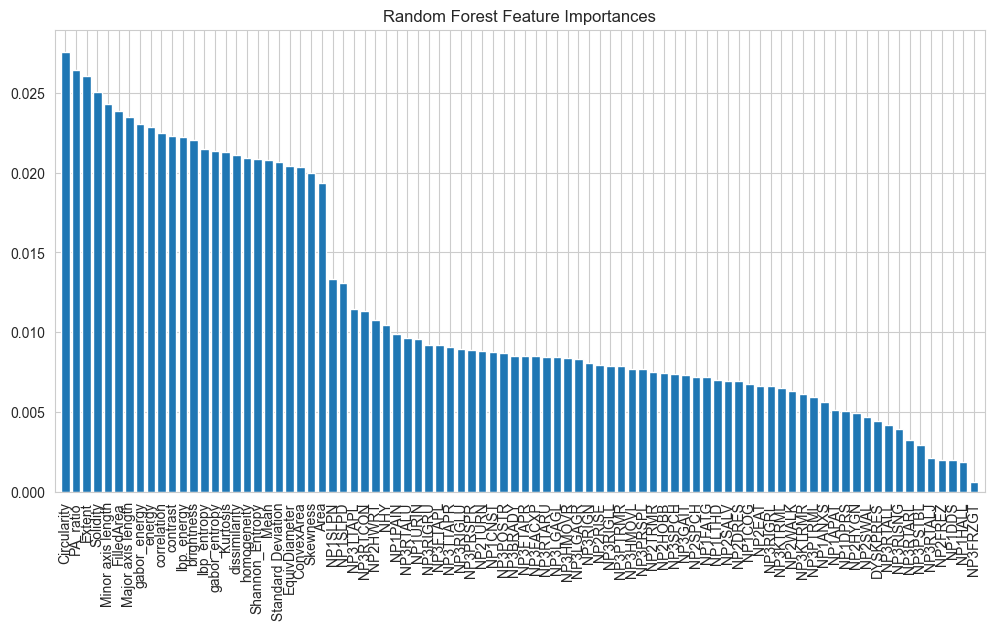

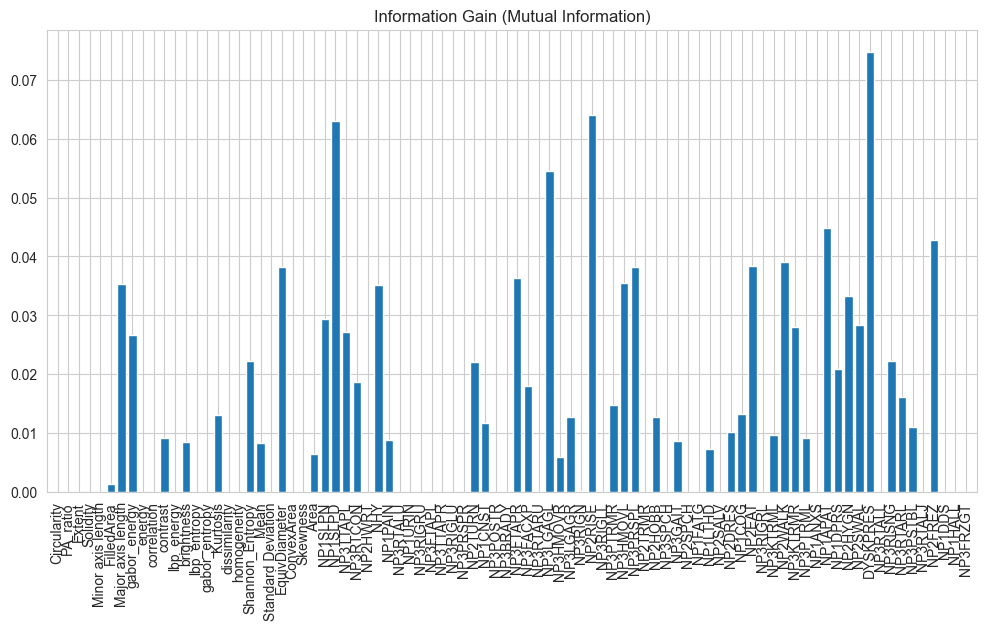

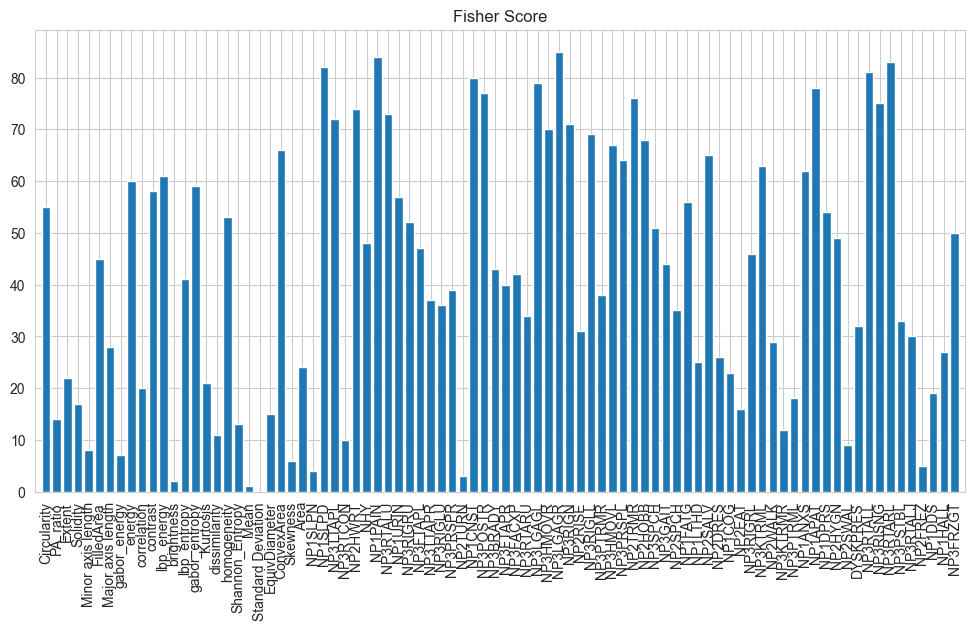

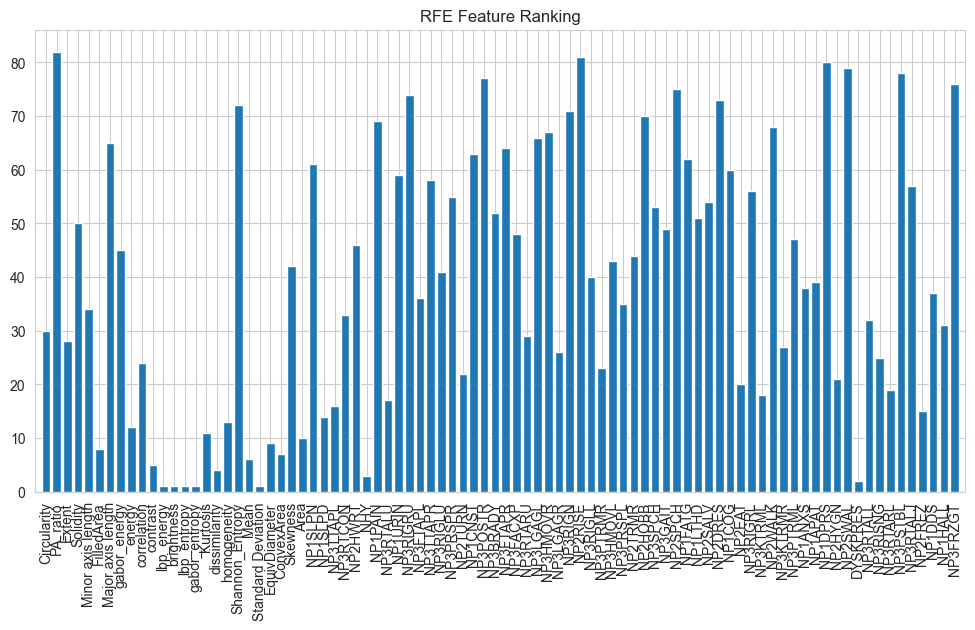

In [63]:
# Assuming df is your DataFrame and 'target' is your target column
X = grouped_master_dataset.drop(columns=['Patient ID', 'Visit Date', 'month_interval', 'Visit_Class', 'EVENT_ID', 'CONCOHORT'])
y = grouped_master_dataset['Visit_Class']

# Standardize features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Random Forest Feature Importance
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_scaled, y)
importances = rf.feature_importances_
indices = np.argsort(importances)[::-1]

plt.figure(figsize=(12, 6))
plt.title('Random Forest Feature Importances')
plt.bar(range(X.shape[1]), importances[indices], align='center')
plt.xticks(range(X.shape[1]), X.columns[indices], rotation=90)
plt.xlim([-1, X.shape[1]])
plt.show()

# Information Gain (Mutual Information)
mi = mutual_info_classif(X_scaled, y)

plt.figure(figsize=(12, 6))
plt.title('Information Gain (Mutual Information)')
plt.bar(range(X.shape[1]), mi[indices], align='center')
plt.xticks(range(X.shape[1]), X.columns[indices], rotation=90)
plt.xlim([-1, X.shape[1]])
plt.show()

# Fisher Score
scores = fisher_score.fisher_score(X_scaled, y.values)

plt.figure(figsize=(12, 6))
plt.title('Fisher Score')
plt.bar(range(X.shape[1]), scores[indices], align='center')
plt.xticks(range(X.shape[1]), X.columns[indices], rotation=90)
plt.xlim([-1, X.shape[1]])
plt.show()

# Recursive Feature Elimination (RFE)
model = LogisticRegression(max_iter=10000)
rfe = RFE(model, n_features_to_select=5)  # Adjust n_features_to_select as needed
rfe = rfe.fit(X_scaled, y)

plt.figure(figsize=(12, 6))
plt.title('RFE Feature Ranking')
plt.bar(range(X.shape[1]), rfe.ranking_[indices], align='center')
plt.xticks(range(X.shape[1]), X.columns[indices], rotation=90)
plt.xlim([-1, X.shape[1]])
plt.show()

In [55]:
# import pandas as pd
# import numpy as np
# import matplotlib.pyplot as plt
# from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
# from sklearn.linear_model import LogisticRegression
# from sklearn.tree import DecisionTreeClassifier
# from sklearn.neural_network import MLPClassifier
# from sklearn.neighbors import KNeighborsClassifier
# from sklearn.svm import SVC
# from sklearn.naive_bayes import GaussianNB
# from xgboost import XGBClassifier
# from sklearn.preprocessing import StandardScaler
# from sklearn.model_selection import train_test_split
# from sklearn.metrics import accuracy_score
# from sklearn.feature_selection import RFE, RFECV
# from sklearn.preprocessing import LabelEncoder
# 
# # Assuming df is your DataFrame and 'target' is your target column
# X = grouped_master_dataset.drop(columns=['Patient ID', 'Visit Date', 'month_interval', 'Visit_Class', 'EVENT_ID', 'CONCOHORT'])
# y = grouped_master_dataset['Visit_Class']
# 
# # Standardize features
# scaler = StandardScaler()
# X_scaled = scaler.fit_transform(X)
# 
# # Transform the target variable
# le = LabelEncoder()
# y = le.fit_transform(y)
# 
# # Recursive Feature Elimination (RFE) with Logistic Regression
# model = LogisticRegression(max_iter=10000)
# # model = DecisionTreeClassifier()
# rfe = RFE(model, n_features_to_select=int(X.shape[1] * 0.25))  # Select top 25% features
# # rfe = RFECV(model)
# rfe.fit(X_scaled, y)
# selected_features = rfe.support_
# # feature_ranks = rfe.ranking_
# 
# # # summarize all features
# # for i in range(X_scaled.shape[1]):
# #     print('Column: %d, Selected %s, Rank: %.3f' % (i, rfe.support_[i], rfe.ranking_[i]))
# 
# 
# # Get the column names of the selected features
# selected_columns = X.columns[selected_features]
# print("Top performing columns:")
# print(selected_columns)
# 
# X_selected = X_scaled[:, selected_features]
# 
# # Split the data
# X_train, X_test, y_train, y_test = train_test_split(X_selected, y, test_size=0.2, random_state=42)
# 
# # List of models
# models = {
#     "Random Forest": RandomForestClassifier(),
#     "Logistic Regression": LogisticRegression(max_iter=10000),
#     "AdaBoost": AdaBoostClassifier(algorithm='SAMME'),
#     "MLP": MLPClassifier(max_iter=10000),
#     "Decision Tree": DecisionTreeClassifier(),
#     "Gradient Boosting": GradientBoostingClassifier(),
#     "KNN": KNeighborsClassifier(),
#     "SVM": SVC(),
#     "Naive Bayes": GaussianNB(),
#     "XGBoost": XGBClassifier(eval_metric='mlogloss')
# }
# 
# # Train and evaluate each model
# results = {}
# for name, model in models.items():
#     model.fit(X_train, y_train)
#     y_pred = model.predict(X_test)
#     accuracy = accuracy_score(y_test, y_pred)
#     results[name] = accuracy
#     print(f"{name} Accuracy: {accuracy:.4f}")
# 
# # Plot the results
# plt.figure(figsize=(12, 6))
# plt.bar(results.keys(), results.values())
# plt.title('Model Accuracy Comparison')
# plt.ylabel('Accuracy')
# plt.xticks(rotation=45)
# plt.show()

In [56]:
# import pandas as pd
# import numpy as np
# import matplotlib.pyplot as plt
# from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
# from sklearn.linear_model import LogisticRegression
# from sklearn.tree import DecisionTreeClassifier
# from sklearn.neural_network import MLPClassifier
# from sklearn.neighbors import KNeighborsClassifier
# from sklearn.svm import SVC
# from sklearn.naive_bayes import GaussianNB
# from xgboost import XGBClassifier
# from sklearn.preprocessing import StandardScaler
# from sklearn.model_selection import train_test_split
# from sklearn.metrics import accuracy_score
# from sklearn.feature_selection import RFE, RFECV
# from sklearn.preprocessing import LabelEncoder
# 
# # Assuming df is your DataFrame and 'target' is your target column
# X = grouped_master_dataset.drop(columns=['Patient ID', 'Visit Date', 'month_interval', 'Visit_Class', 'EVENT_ID', 'CONCOHORT'])
# y = grouped_master_dataset['Visit_Class']
# 
# # Standardize features
# scaler = StandardScaler()
# X_scaled = scaler.fit_transform(X)
# 
# # Transform the target variable
# le = LabelEncoder()
# y = le.fit_transform(y)
# 
# # Recursive Feature Elimination (RFE) with Logistic Regression
# model = LogisticRegression(max_iter=10000)
# # model = DecisionTreeClassifier()
# rfe = RFE(model, n_features_to_select=int(X.shape[1] * 0.5))  # Select top 50% features
# # rfe = RFECV(model)
# rfe.fit(X_scaled, y)
# selected_features = rfe.support_
# # feature_ranks = rfe.ranking_
# 
# # # summarize all features
# # for i in range(X_scaled.shape[1]):
# #     print('Column: %d, Selected %s, Rank: %.3f' % (i, rfe.support_[i], rfe.ranking_[i]))
# 
# 
# # Get the column names of the selected features
# selected_columns = X.columns[selected_features]
# print("Top performing columns:")
# print(selected_columns)
# 
# X_selected = X_scaled[:, selected_features]
# 
# # Split the data
# X_train, X_test, y_train, y_test = train_test_split(X_selected, y, test_size=0.2, random_state=42)
# 
# # List of models
# models = {
#     "Random Forest": RandomForestClassifier(),
#     "Logistic Regression": LogisticRegression(max_iter=10000),
#     "AdaBoost": AdaBoostClassifier(algorithm='SAMME'),
#     "MLP": MLPClassifier(max_iter=10000),
#     "Decision Tree": DecisionTreeClassifier(),
#     "Gradient Boosting": GradientBoostingClassifier(),
#     "KNN": KNeighborsClassifier(),
#     "SVM": SVC(),
#     "Naive Bayes": GaussianNB(),
#     "XGBoost": XGBClassifier(eval_metric='mlogloss')
# }
# 
# # Train and evaluate each model
# results = {}
# for name, model in models.items():
#     model.fit(X_train, y_train)
#     y_pred = model.predict(X_test)
#     accuracy = accuracy_score(y_test, y_pred)
#     results[name] = accuracy
#     print(f"{name} Accuracy: {accuracy:.4f}")
# 
# # Plot the results
# plt.figure(figsize=(12, 6))
# plt.bar(results.keys(), results.values())
# plt.title('Model Accuracy Comparison')
# plt.ylabel('Accuracy')
# plt.xticks(rotation=45)
# plt.show()

In [57]:
# import pandas as pd
# import numpy as np
# import matplotlib.pyplot as plt
# from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
# from sklearn.linear_model import LogisticRegression
# from sklearn.tree import DecisionTreeClassifier
# from sklearn.neural_network import MLPClassifier
# from sklearn.neighbors import KNeighborsClassifier
# from sklearn.svm import SVC
# from sklearn.naive_bayes import GaussianNB
# from xgboost import XGBClassifier
# from sklearn.preprocessing import StandardScaler
# from sklearn.model_selection import train_test_split
# from sklearn.metrics import accuracy_score
# from sklearn.feature_selection import RFE, RFECV
# from sklearn.preprocessing import LabelEncoder
# 
# # Assuming df is your DataFrame and 'target' is your target column
# X = grouped_master_dataset.drop(columns=['Patient ID', 'Visit Date', 'month_interval', 'Visit_Class', 'EVENT_ID', 'CONCOHORT'])
# y = grouped_master_dataset['Visit_Class']
# 
# # Standardize features
# scaler = StandardScaler()
# X_scaled = scaler.fit_transform(X)
# 
# # Transform the target variable
# le = LabelEncoder()
# y = le.fit_transform(y)
# 
# # Recursive Feature Elimination (RFE) with Logistic Regression
# model = LogisticRegression(max_iter=10000)
# # model = DecisionTreeClassifier()
# rfe = RFE(model, n_features_to_select=int(X.shape[1] * 0.75))  # Select top 75% features
# # rfe = RFECV(model)
# rfe.fit(X_scaled, y)
# selected_features = rfe.support_
# # feature_ranks = rfe.ranking_
# 
# # # summarize all features
# # for i in range(X_scaled.shape[1]):
# #     print('Column: %d, Selected %s, Rank: %.3f' % (i, rfe.support_[i], rfe.ranking_[i]))
# 
# 
# # Get the column names of the selected features
# selected_columns = X.columns[selected_features]
# print("Top performing columns:")
# print(selected_columns)
# 
# X_selected = X_scaled[:, selected_features]
# 
# # Split the data
# X_train, X_test, y_train, y_test = train_test_split(X_selected, y, test_size=0.2, random_state=42)
# 
# # List of models
# models = {
#     "Random Forest": RandomForestClassifier(),
#     "Logistic Regression": LogisticRegression(max_iter=10000),
#     "AdaBoost": AdaBoostClassifier(algorithm='SAMME'),
#     "MLP": MLPClassifier(max_iter=10000),
#     "Decision Tree": DecisionTreeClassifier(),
#     "Gradient Boosting": GradientBoostingClassifier(),
#     "KNN": KNeighborsClassifier(),
#     "SVM": SVC(),
#     "Naive Bayes": GaussianNB(),
#     "XGBoost": XGBClassifier(eval_metric='mlogloss')
# }
# 
# # Train and evaluate each model
# results = {}
# for name, model in models.items():
#     model.fit(X_train, y_train)
#     y_pred = model.predict(X_test)
#     accuracy = accuracy_score(y_test, y_pred)
#     results[name] = accuracy
#     print(f"{name} Accuracy: {accuracy:.4f}")
# 
# # Plot the results
# plt.figure(figsize=(12, 6))
# plt.bar(results.keys(), results.values())
# plt.title('Model Accuracy Comparison')
# plt.ylabel('Accuracy')
# plt.xticks(rotation=45)
# plt.show()

## Recursive Feature Elimination

Top performing columns for 25% features:
Index(['NP3TTAPL', 'NP3RTALU', 'DYSKPRES', 'NHY', 'NP2FREZ', 'NP1SLPD', 'Area',
       'ConvexArea', 'EquivDiameter', 'FilledArea', 'Kurtosis', 'Mean',
       'Standard Deviation', 'brightness', 'contrast', 'dissimilarity',
       'energy', 'gabor_entropy', 'homogeneity', 'lbp_energy', 'lbp_entropy'],
      dtype='object')
Random Forest Accuracy with 25% features: 0.3333
Logistic Regression Accuracy with 25% features: 0.3661
AdaBoost Accuracy with 25% features: 0.3169
MLP Accuracy with 25% features: 0.3443
Decision Tree Accuracy with 25% features: 0.2951
Gradient Boosting Accuracy with 25% features: 0.3169
KNN Accuracy with 25% features: 0.3661
SVM Accuracy with 25% features: 0.3880
Naive Bayes Accuracy with 25% features: 0.2896
XGBoost Accuracy with 25% features: 0.3607


/tmp/ipykernel_13795/819786821.py:64: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(results.keys(), rotation=45)


Top performing columns for 50% features:
Index(['NP3FTAPL', 'NP3PRSPL', 'NP3TTAPL', 'NP3LGAGR', 'NP3RISNG', 'NP3PTRMR',
       'NP3KTRMR', 'NP3KTRML', 'NP3RTARU', 'NP3RTALU', 'NP3RTARL', 'NP3RTALL',
       'NP3RTCON', 'DYSKPRES', 'NHY', 'NP2EAT', 'NP2HYGN', 'NP2TURN',
       'NP2FREZ', 'NP1SLPD', 'NP1HALL', 'NP1ANXS', 'NP1APAT', 'NP1DDS', 'Area',
       'Circularity', 'ConvexArea', 'EquivDiameter', 'Extent', 'FilledArea',
       'Kurtosis', 'Mean', 'Minor axis length', 'Standard Deviation',
       'brightness', 'contrast', 'correlation', 'dissimilarity', 'energy',
       'gabor_entropy', 'homogeneity', 'lbp_energy', 'lbp_entropy'],
      dtype='object')
Random Forest Accuracy with 50% features: 0.3443
Logistic Regression Accuracy with 50% features: 0.3989
AdaBoost Accuracy with 50% features: 0.3552
MLP Accuracy with 50% features: 0.3388
Decision Tree Accuracy with 50% features: 0.3005
Gradient Boosting Accuracy with 50% features: 0.2951
KNN Accuracy with 50% features: 0.3497
SVM Accura

/tmp/ipykernel_13795/819786821.py:64: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(results.keys(), rotation=45)


Top performing columns for 75% features:
Index(['NP3SPCH', 'NP3FACXP', 'NP3RIGLU', 'NP3RIGRL', 'NP3RIGLL', 'NP3FTAPL',
       'NP3HMOVL', 'NP3PRSPR', 'NP3PRSPL', 'NP3TTAPR', 'NP3TTAPL', 'NP3LGAGR',
       'NP3RISNG', 'NP3GAIT', 'NP3BRADY', 'NP3PTRMR', 'NP3PTRML', 'NP3KTRMR',
       'NP3KTRML', 'NP3RTARU', 'NP3RTALU', 'NP3RTARL', 'NP3RTALL', 'NP3RTALJ',
       'NP3RTCON', 'DYSKPRES', 'NHY', 'NP2SALV', 'NP2EAT', 'NP2HYGN',
       'NP2HWRT', 'NP2TURN', 'NP2TRMR', 'NP2FREZ', 'NP1SLPD', 'NP1URIN',
       'NP1LTHD', 'NP1COG', 'NP1HALL', 'NP1ANXS', 'NP1APAT', 'NP1DDS', 'Area',
       'Circularity', 'ConvexArea', 'EquivDiameter', 'Extent', 'FilledArea',
       'Kurtosis', 'Mean', 'Minor axis length', 'Skewness', 'Solidity',
       'Standard Deviation', 'brightness', 'contrast', 'correlation',
       'dissimilarity', 'energy', 'gabor_energy', 'gabor_entropy',
       'homogeneity', 'lbp_energy', 'lbp_entropy'],
      dtype='object')
Random Forest Accuracy with 75% features: 0.3443
Logistic Regre

/tmp/ipykernel_13795/819786821.py:64: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(results.keys(), rotation=45)


Random Forest Accuracy with 100% features: 0.3497
Logistic Regression Accuracy with 100% features: 0.4098
AdaBoost Accuracy with 100% features: 0.3169
MLP Accuracy with 100% features: 0.3279
Decision Tree Accuracy with 100% features: 0.2568
Gradient Boosting Accuracy with 100% features: 0.3552
KNN Accuracy with 100% features: 0.3005
SVM Accuracy with 100% features: 0.3880
Naive Bayes Accuracy with 100% features: 0.3224
XGBoost Accuracy with 100% features: 0.3388


/tmp/ipykernel_13795/819786821.py:64: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(results.keys(), rotation=45)


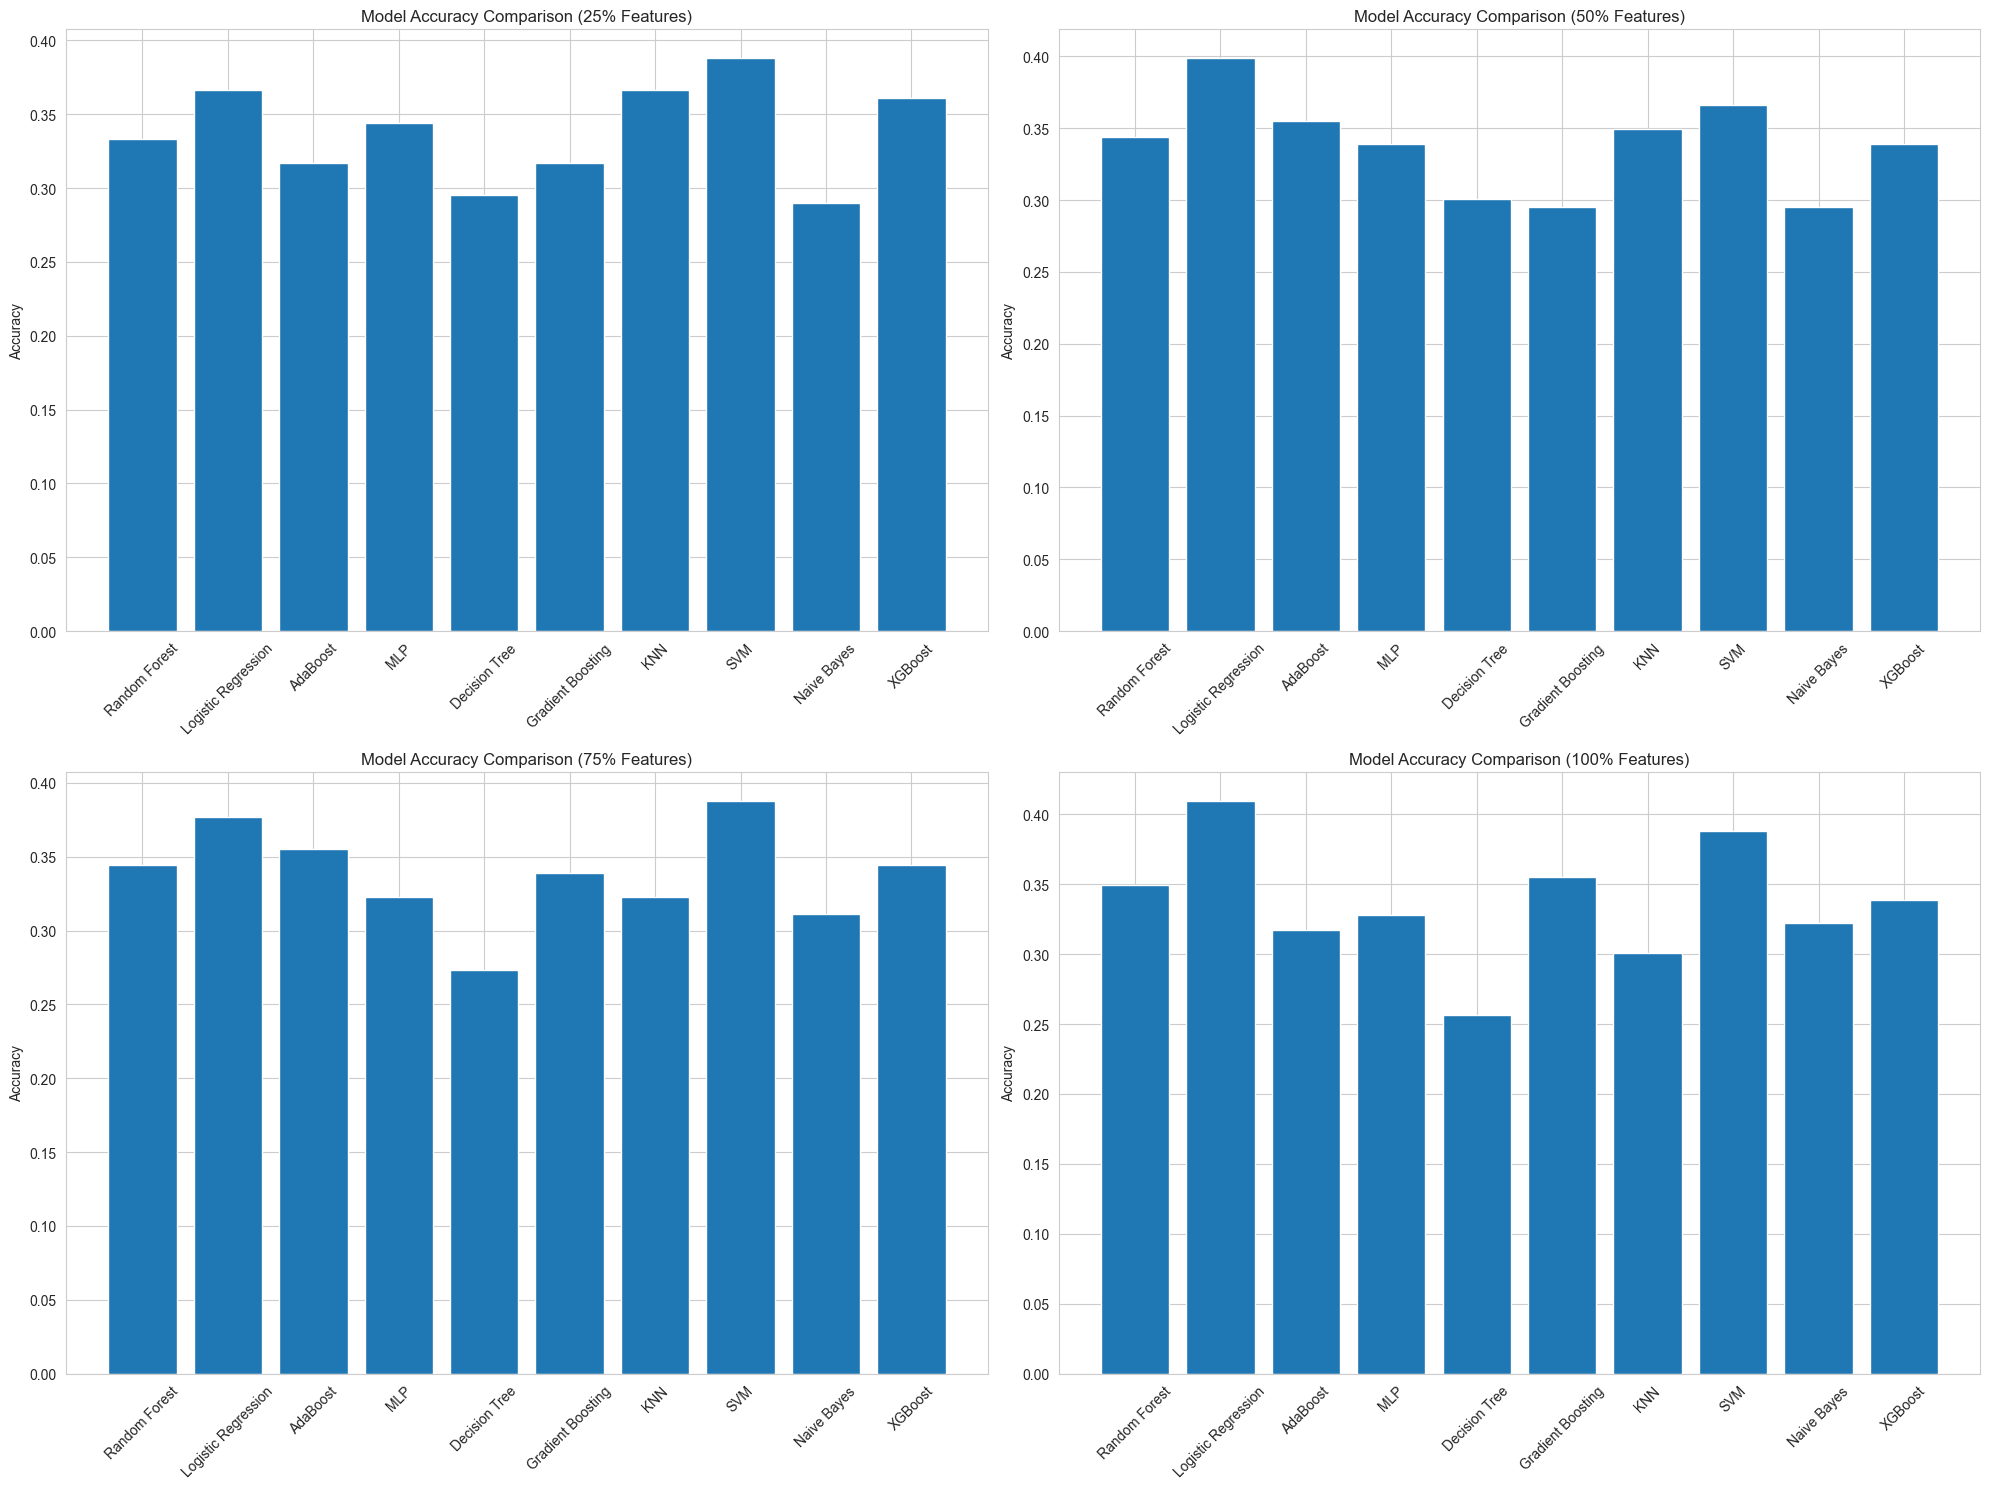

In [64]:
# Assuming df is your DataFrame and 'target' is your target column
X = grouped_master_dataset.drop(columns=['Patient ID', 'Visit Date', 'month_interval', 'Visit_Class', 'EVENT_ID', 'CONCOHORT'])
y = grouped_master_dataset['Visit_Class']

# Standardize features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Transform the target variable
le = LabelEncoder()
y = le.fit_transform(y)

# Define the percentages of features to select
feature_percentages = [0.25, 0.50, 0.75, 1.00]

# List of models
models = {
    "Random Forest": RandomForestClassifier(),
    "Logistic Regression": LogisticRegression(max_iter=10000),
    "AdaBoost": AdaBoostClassifier(algorithm='SAMME'),
    "MLP": MLPClassifier(max_iter=10000),
    "Decision Tree": DecisionTreeClassifier(),
    "Gradient Boosting": GradientBoostingClassifier(),
    "KNN": KNeighborsClassifier(),
    "SVM": SVC(),
    "Naive Bayes": GaussianNB(),
    "XGBoost": XGBClassifier(eval_metric='mlogloss')
}

fig, axs = plt.subplots(2, 2, figsize=(20, 15))

for i, percentage in enumerate(feature_percentages):
    # Recursive Feature Elimination (RFE) with Logistic Regression
    model = LogisticRegression(max_iter=10000)
    n_features_to_select = int(X.shape[1] * percentage)
    rfe = RFE(model, n_features_to_select=n_features_to_select)
    rfe.fit(X_scaled, y)
    selected_features = rfe.support_

    # Get the column names of the selected features
    selected_columns = X.columns[selected_features]
    print(f"Top performing columns for {int(percentage * 100)}% features:")
    print(selected_columns)

    X_selected = X_scaled[:, selected_features]

    # Split the data
    X_train, X_test, y_train, y_test = train_test_split(X_selected, y, test_size=0.2, random_state=42)

    # Train and evaluate each model
    results = {}
    for name, model in models.items():
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        accuracy = accuracy_score(y_test, y_pred)
        results[name] = accuracy
        print(f"{name} Accuracy with {int(percentage * 100)}% features: {accuracy:.4f}")

    # Plot the results
    ax = axs[i // 2, i % 2]
    ax.bar(results.keys(), results.values())
    ax.set_title(f'Model Accuracy Comparison ({int(percentage * 100)}% Features)')
    ax.set_ylabel('Accuracy')
    ax.set_xticklabels(results.keys(), rotation=45)

plt.tight_layout()
plt.show()

## Random Forest Feature Extraction

Top performing columns for 25% features:
Index(['Circularity', 'PA_ratio', 'Extent', 'Solidity', 'Minor axis length',
       'FilledArea', 'Major axis length', 'gabor_energy', 'energy',
       'correlation', 'contrast', 'lbp_energy', 'brightness', 'lbp_entropy',
       'gabor_entropy', 'Kurtosis', 'dissimilarity', 'homogeneity',
       'Shannon_Entropy', 'Mean', 'Standard Deviation'],
      dtype='object')
Random Forest Accuracy with 25% features: 0.2623
Logistic Regression Accuracy with 25% features: 0.2678
AdaBoost Accuracy with 25% features: 0.2787
MLP Accuracy with 25% features: 0.3005
Decision Tree Accuracy with 25% features: 0.2186
Gradient Boosting Accuracy with 25% features: 0.2678
KNN Accuracy with 25% features: 0.2678
SVM Accuracy with 25% features: 0.3169
Naive Bayes Accuracy with 25% features: 0.3333
XGBoost Accuracy with 25% features: 0.2568


/tmp/ipykernel_13795/2330468191.py:69: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(results.keys(), rotation=45)


Top performing columns for 50% features:
Index(['Circularity', 'PA_ratio', 'Extent', 'Solidity', 'Minor axis length',
       'FilledArea', 'Major axis length', 'gabor_energy', 'energy',
       'correlation', 'contrast', 'lbp_energy', 'brightness', 'lbp_entropy',
       'gabor_entropy', 'Kurtosis', 'dissimilarity', 'homogeneity',
       'Shannon_Entropy', 'Mean', 'Standard Deviation', 'EquivDiameter',
       'ConvexArea', 'Skewness', 'Area', 'NP1SLPN', 'NP1SLPD', 'NP3TTAPL',
       'NP3RTCON', 'NP2HWRT', 'NHY', 'NP1PAIN', 'NP3RTALU', 'NP1URIN',
       'NP3RIGRU', 'NP3FTAPL', 'NP3TTAPR', 'NP3RIGLU', 'NP3PRSPR', 'NP2TURN',
       'NP1CNST', 'NP3POSTR', 'NP3BRADY'],
      dtype='object')
Random Forest Accuracy with 50% features: 0.3607
Logistic Regression Accuracy with 50% features: 0.3443
AdaBoost Accuracy with 50% features: 0.3607
MLP Accuracy with 50% features: 0.3060
Decision Tree Accuracy with 50% features: 0.3333
Gradient Boosting Accuracy with 50% features: 0.3497
KNN Accuracy with 

/tmp/ipykernel_13795/2330468191.py:69: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(results.keys(), rotation=45)


Top performing columns for 75% features:
Index(['Circularity', 'PA_ratio', 'Extent', 'Solidity', 'Minor axis length',
       'FilledArea', 'Major axis length', 'gabor_energy', 'energy',
       'correlation', 'contrast', 'lbp_energy', 'brightness', 'lbp_entropy',
       'gabor_entropy', 'Kurtosis', 'dissimilarity', 'homogeneity',
       'Shannon_Entropy', 'Mean', 'Standard Deviation', 'EquivDiameter',
       'ConvexArea', 'Skewness', 'Area', 'NP1SLPN', 'NP1SLPD', 'NP3TTAPL',
       'NP3RTCON', 'NP2HWRT', 'NHY', 'NP1PAIN', 'NP3RTALU', 'NP1URIN',
       'NP3RIGRU', 'NP3FTAPL', 'NP3TTAPR', 'NP3RIGLU', 'NP3PRSPR', 'NP2TURN',
       'NP1CNST', 'NP3POSTR', 'NP3BRADY', 'NP3FTAPR', 'NP3FACXP', 'NP3RTARU',
       'NP3LGAGL', 'NP3HMOVR', 'NP3LGAGR', 'NP3RIGN', 'NP2RISE', 'NP3RIGLL',
       'NP3PTRMR', 'NP3HMOVL', 'NP3PRSPL', 'NP2TRMR', 'NP2HOBB', 'NP3SPCH',
       'NP3GAIT', 'NP2SPCH', 'NP1FATG', 'NP1LTHD', 'NP2SALV', 'NP2DRES'],
      dtype='object')
Random Forest Accuracy with 75% features: 0.3

/tmp/ipykernel_13795/2330468191.py:69: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(results.keys(), rotation=45)


Top performing columns for 100% features:
Index(['Circularity', 'PA_ratio', 'Extent', 'Solidity', 'Minor axis length',
       'FilledArea', 'Major axis length', 'gabor_energy', 'energy',
       'correlation', 'contrast', 'lbp_energy', 'brightness', 'lbp_entropy',
       'gabor_entropy', 'Kurtosis', 'dissimilarity', 'homogeneity',
       'Shannon_Entropy', 'Mean', 'Standard Deviation', 'EquivDiameter',
       'ConvexArea', 'Skewness', 'Area', 'NP1SLPN', 'NP1SLPD', 'NP3TTAPL',
       'NP3RTCON', 'NP2HWRT', 'NHY', 'NP1PAIN', 'NP3RTALU', 'NP1URIN',
       'NP3RIGRU', 'NP3FTAPL', 'NP3TTAPR', 'NP3RIGLU', 'NP3PRSPR', 'NP2TURN',
       'NP1CNST', 'NP3POSTR', 'NP3BRADY', 'NP3FTAPR', 'NP3FACXP', 'NP3RTARU',
       'NP3LGAGL', 'NP3HMOVR', 'NP3LGAGR', 'NP3RIGN', 'NP2RISE', 'NP3RIGLL',
       'NP3PTRMR', 'NP3HMOVL', 'NP3PRSPL', 'NP2TRMR', 'NP2HOBB', 'NP3SPCH',
       'NP3GAIT', 'NP2SPCH', 'NP1FATG', 'NP1LTHD', 'NP2SALV', 'NP2DRES',
       'NP1COG', 'NP2EAT', 'NP3RIGRL', 'NP3KTRML', 'NP2WALK', 'NP3K

/tmp/ipykernel_13795/2330468191.py:69: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(results.keys(), rotation=45)


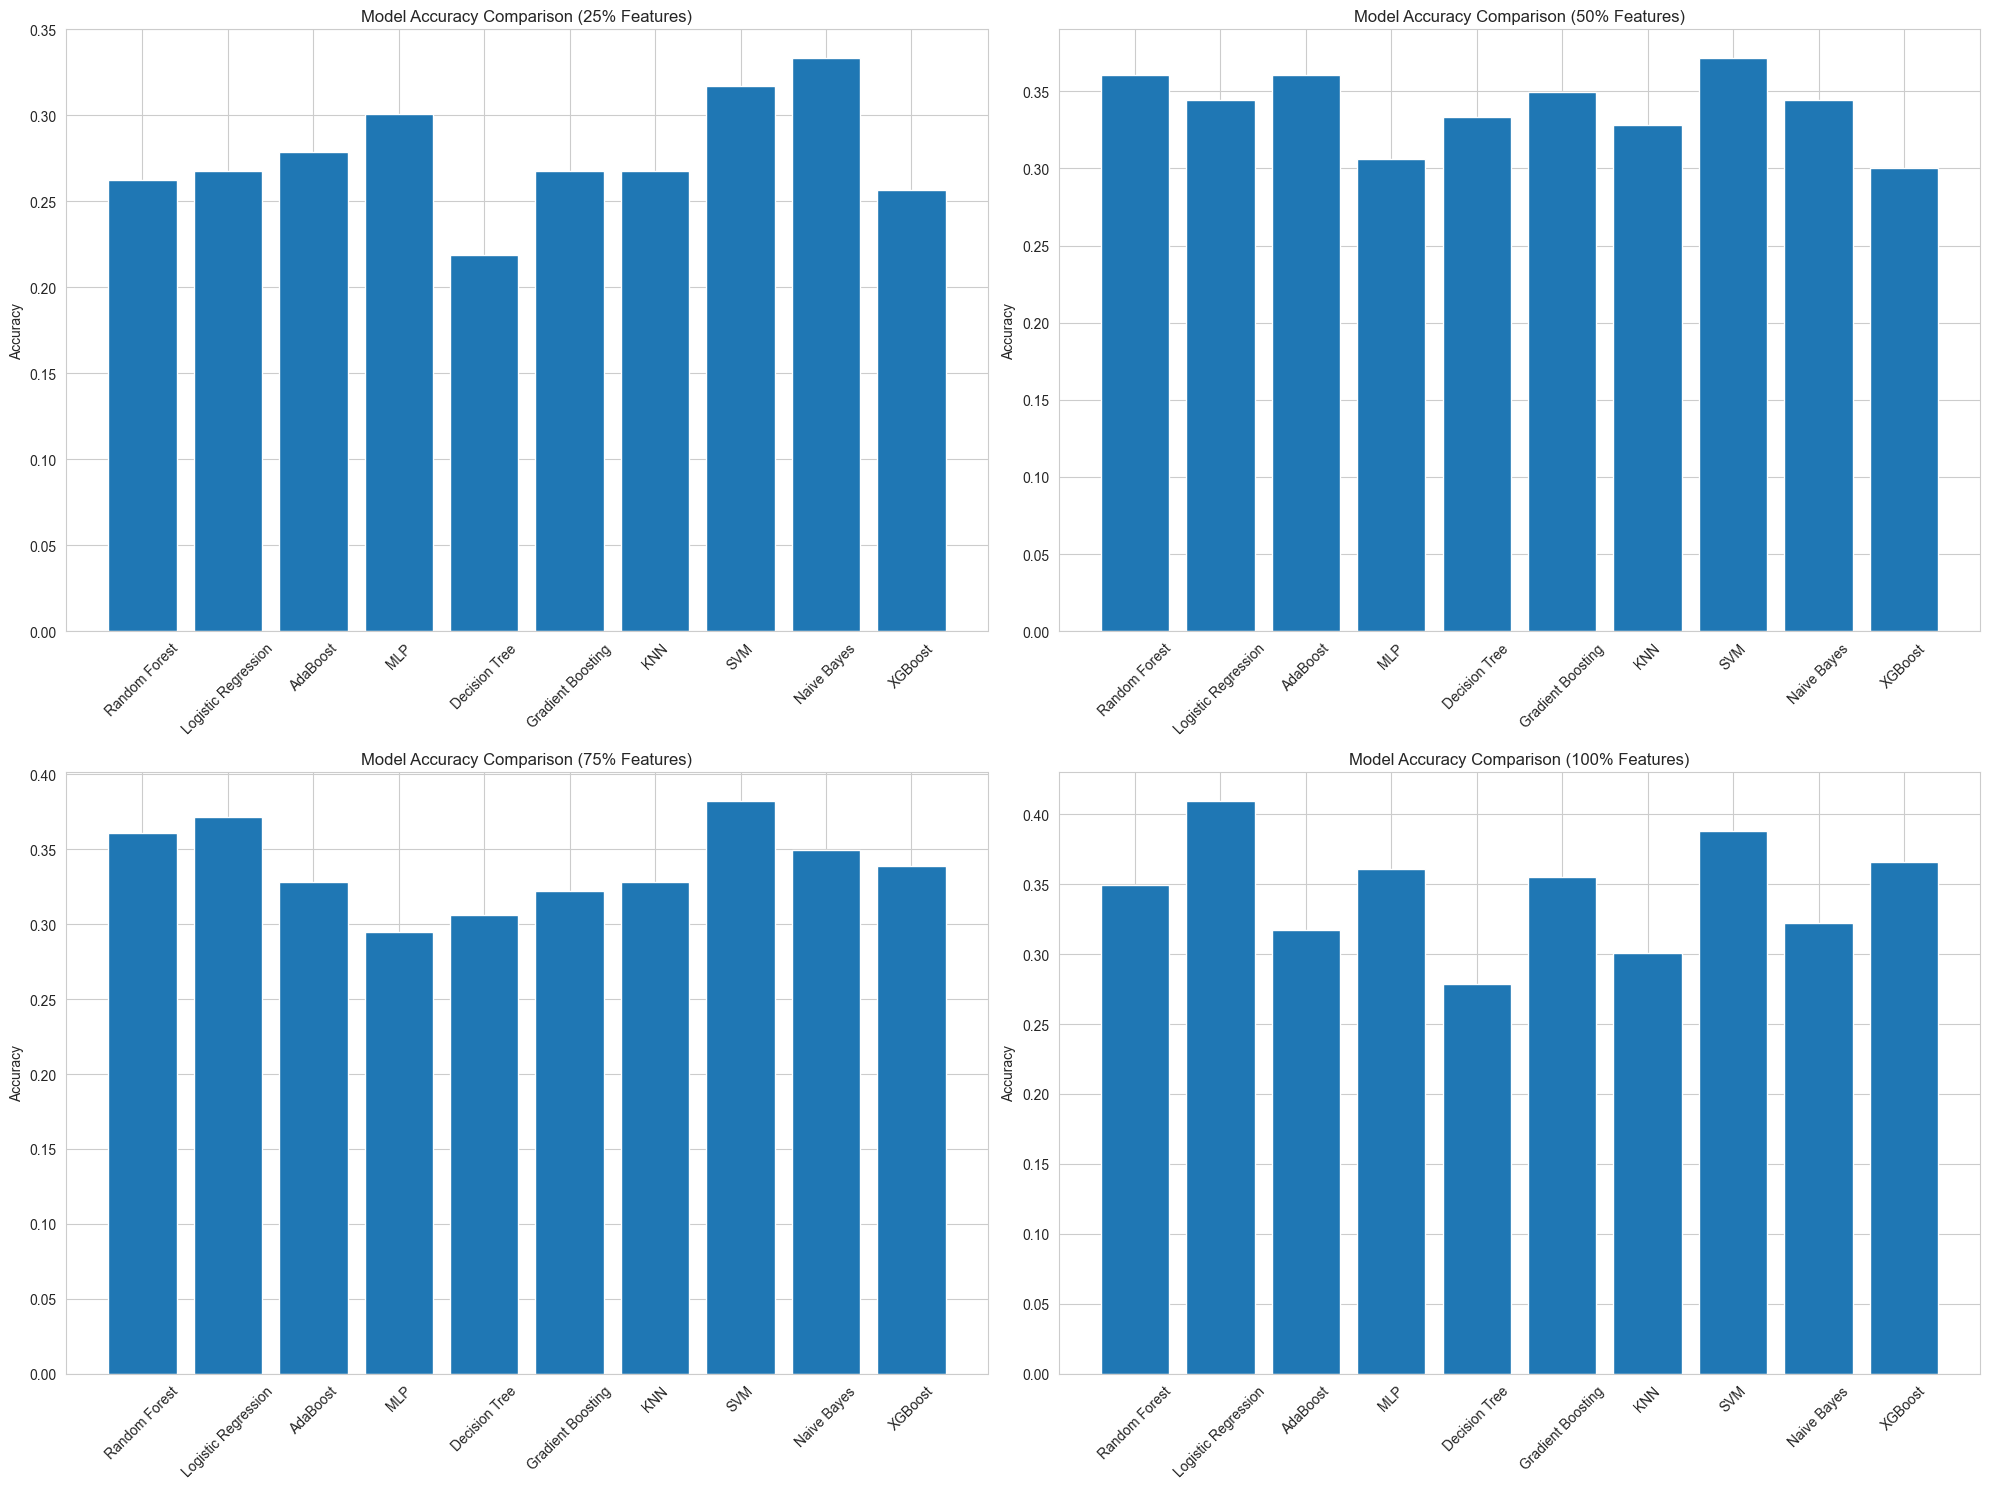

In [65]:
# Assuming df is your DataFrame and 'target' is your target column
X = grouped_master_dataset.drop(columns=['Patient ID', 'Visit Date', 'month_interval', 'Visit_Class', 'EVENT_ID', 'CONCOHORT'])
y = grouped_master_dataset['Visit_Class']

# Standardize features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Transform the target variable
le = LabelEncoder()
y = le.fit_transform(y)

# Define the percentages of features to select
feature_percentages = [0.25, 0.50, 0.75, 1.00]

# List of models
models = {
    "Random Forest": RandomForestClassifier(),
    "Logistic Regression": LogisticRegression(max_iter=10000),
    "AdaBoost": AdaBoostClassifier(algorithm='SAMME'),
    "MLP": MLPClassifier(max_iter=10000),
    "Decision Tree": DecisionTreeClassifier(),
    "Gradient Boosting": GradientBoostingClassifier(),
    "KNN": KNeighborsClassifier(),
    "SVM": SVC(),
    "Naive Bayes": GaussianNB(),
    "XGBoost": XGBClassifier(eval_metric='mlogloss')
}

fig, axs = plt.subplots(2, 2, figsize=(20, 15))

for i, percentage in enumerate(feature_percentages):
    # Random Forest Feature Importance
    model = RandomForestClassifier(n_estimators=100, random_state=42)
    model.fit(X_scaled, y)
    importances = model.feature_importances_

    # Sort the feature indices by importance score
    indices = np.argsort(importances)[::-1]

    # Calculate the number of features to select
    n_features_to_select = int(len(indices) * percentage)

    # Select the top N% features
    selected_indices = indices[:n_features_to_select]
    selected_columns = X.columns[selected_indices]
    print(f"Top performing columns for {int(percentage * 100)}% features:")
    print(selected_columns)

    X_selected = X_scaled[:, selected_indices]

    # Split the data
    X_train, X_test, y_train, y_test = train_test_split(X_selected, y, test_size=0.2, random_state=42)

    # Train and evaluate each model
    results = {}
    for name, model in models.items():
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        accuracy = accuracy_score(y_test, y_pred)
        results[name] = accuracy
        print(f"{name} Accuracy with {int(percentage * 100)}% features: {accuracy:.4f}")

    # Plot the results
    ax = axs[i // 2, i % 2]
    ax.bar(results.keys(), results.values())
    ax.set_title(f'Model Accuracy Comparison ({int(percentage * 100)}% Features)')
    ax.set_ylabel('Accuracy')
    ax.set_xticklabels(results.keys(), rotation=45)

plt.tight_layout()
plt.show()

## Information Gain

Top performing columns for 25% features:
Index(['NHY', 'NP1FATG', 'NP3RIGLU', 'NP2HWRT', 'NP3LGAGL', 'EquivDiameter',
       'NP3GAIT', 'NP3SPCH', 'NP3POSTR', 'Major axis length', 'NP3RTCON',
       'NP2HOBB', 'NP3RTALJ', 'NP2TURN', 'NP2TRMR', 'gabor_energy', 'NP3BRADY',
       'NP2FREZ', 'Shannon_Entropy', 'NP3HMOVR', 'NP3TTAPR'],
      dtype='object')
Random Forest Accuracy with 25% features: 0.2842
Logistic Regression Accuracy with 25% features: 0.3388
AdaBoost Accuracy with 25% features: 0.3279
MLP Accuracy with 25% features: 0.2678
Decision Tree Accuracy with 25% features: 0.3333
Gradient Boosting Accuracy with 25% features: 0.2951
KNN Accuracy with 25% features: 0.2459
SVM Accuracy with 25% features: 0.3279
Naive Bayes Accuracy with 25% features: 0.3279
XGBoost Accuracy with 25% features: 0.2514


/tmp/ipykernel_13795/4042334328.py:67: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(results.keys(), rotation=45)


Top performing columns for 50% features:
Index(['NHY', 'NP1ANXS', 'NP3TTAPL', 'EquivDiameter', 'NP2RISE', 'NP3PTRML',
       'NP1DDS', 'NP3RTALJ', 'NP3RIGLU', 'Major axis length', 'NP3FRZGT',
       'NP3PRSPR', 'NP3PTRMR', 'NP2SALV', 'NP1LTHD', 'NP1CNST', 'NP3LGAGL',
       'DYSKPRES', 'gabor_energy', 'NP1DPRS', 'NP3HMOVL', 'NP3RTALU',
       'NP3RIGRU', 'Shannon_Entropy', 'NP1SLPN', 'NP3FTAPR', 'NP3POSTR',
       'NP2HOBB', 'NP2HYGN', 'NP1FATG', 'NP2DRES', 'NP3GAIT', 'Kurtosis',
       'NP3PRSPL', 'NP3KTRMR', 'contrast', 'NP2EAT', 'brightness', 'Mean',
       'NP1PAIN', 'NP3RTARL', 'NP3RISNG', 'Area'],
      dtype='object')
Random Forest Accuracy with 50% features: 0.3607
Logistic Regression Accuracy with 50% features: 0.3716
AdaBoost Accuracy with 50% features: 0.3169
MLP Accuracy with 50% features: 0.3224
Decision Tree Accuracy with 50% features: 0.2568
Gradient Boosting Accuracy with 50% features: 0.3279
KNN Accuracy with 50% features: 0.3005
SVM Accuracy with 50% features: 0.3716


/tmp/ipykernel_13795/4042334328.py:67: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(results.keys(), rotation=45)


Top performing columns for 75% features:
Index(['NP2SPCH', 'NP3BRADY', 'NP3POSTR', 'NP3FTAPL', 'NP3RIGN', 'NP3RTALU',
       'NP2WALK', 'EquivDiameter', 'Major axis length', 'NP3SPCH', 'NP3FACXP',
       'gabor_energy', 'NHY', 'NP3TTAPL', 'NP1COG', 'NP3RIGLU', 'NP1DDS',
       'NP1ANXS', 'NP1PAIN', 'Shannon_Entropy', 'NP2SALV', 'NP3RIGRU',
       'NP2HYGN', 'NP1APAT', 'NP2RISE', 'NP2TRMR', 'NP3PTRMR', 'NP1SLPN',
       'NP1URIN', 'Kurtosis', 'NP3KTRMR', 'NP2TURN', 'NP2DRES', 'NP1SLPD',
       'NP3RTCON', 'NP3KTRML', 'contrast', 'NP3RIGLL', 'brightness',
       'NP3LGAGL', 'Mean', 'NP3RTARL', 'Area', 'NP3HMOVR', 'NP3PRSPR',
       'NP3RTARU', 'NP1HALL', 'NP3RIGRL', 'NP3RTALL', 'NP1CNST', 'FilledArea',
       'NP3HMOVL', 'NP3PSTBL', 'NP3FRZGT', 'NP3GAIT', 'NP3LGAGR', 'NP3PTRML',
       'NP3FTAPR', 'NP3TTAPR', 'NP3PRSPL', 'NP3RISNG', 'lbp_entropy',
       'NP3RTALJ', 'DYSKPRES'],
      dtype='object')
Random Forest Accuracy with 75% features: 0.3333
Logistic Regression Accuracy with 75% f

/tmp/ipykernel_13795/4042334328.py:67: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(results.keys(), rotation=45)


Top performing columns for 100% features:
Index(['NP1PAIN', 'NP2DRES', 'DYSKPRES', 'NP3FACXP', 'NP1ANXS',
       'EquivDiameter', 'NP3RTALL', 'NP1SLPD', 'Major axis length', 'NP3GAIT',
       'NP3RTARL', 'NP1APAT', 'NP2RISE', 'NP3RTARU', 'NP3PRSPL', 'NP2FREZ',
       'NP3RIGLU', 'NP3RIGLL', 'NP1COG', 'gabor_energy', 'NP2TURN', 'NP3FTAPR',
       'NP3PRSPR', 'Shannon_Entropy', 'NP3HMOVL', 'NP1URIN', 'NP1DDS',
       'NP1CNST', 'NP3TTAPL', 'NP3HMOVR', 'NP3TTAPR', 'NP1HALL', 'NP3RTALJ',
       'NP2EAT', 'NP3RIGRL', 'NP3BRADY', 'Kurtosis', 'NP3LGAGR', 'NP2WALK',
       'NP3FRZGT', 'NP1SLPN', 'contrast', 'NP1FATG', 'brightness', 'Mean',
       'NP1LTHD', 'NP2HYGN', 'Area', 'FilledArea', 'NP2HWRT', 'NP3PTRML',
       'NP3RIGRU', 'NP3POSTR', 'lbp_entropy', 'NP3PSTBL', 'NP3RISNG',
       'NP3LGAGL', 'NP3FTAPL', 'NP3RIGN', 'NP3PTRMR', 'NP2HOBB', 'NP3KTRMR',
       'Extent', 'homogeneity', 'gabor_entropy', 'energy', 'dissimilarity',
       'correlation', 'Standard Deviation', 'Solidity', 'Skewne

/tmp/ipykernel_13795/4042334328.py:67: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(results.keys(), rotation=45)


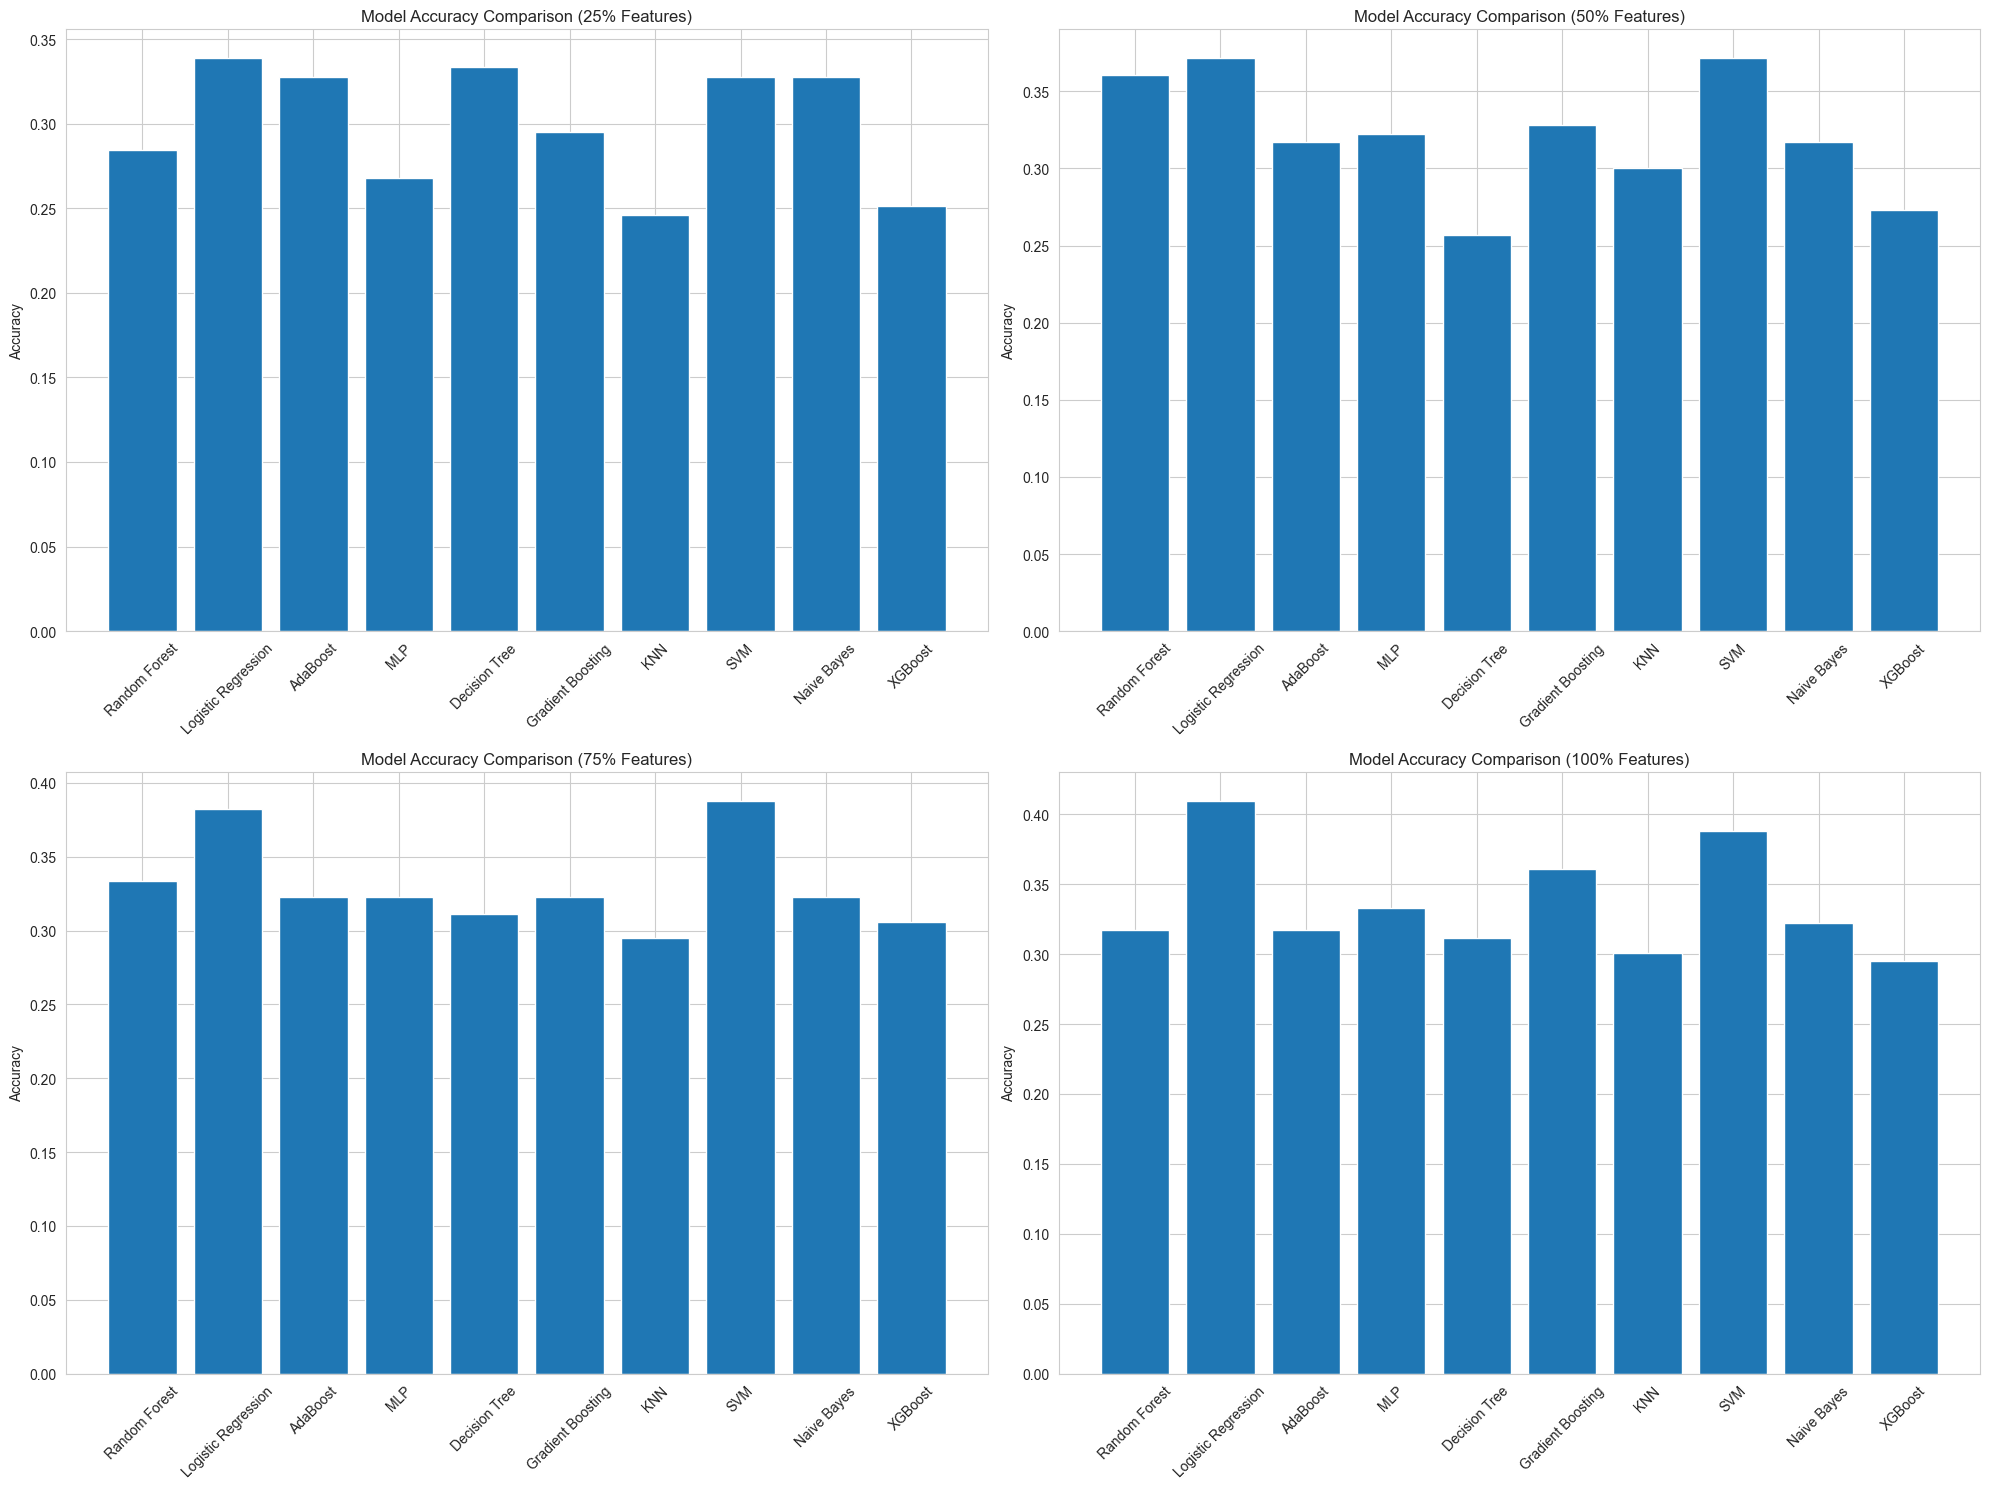

In [66]:
# Assuming df is your DataFrame and 'target' is your target column
X = grouped_master_dataset.drop(columns=['Patient ID', 'Visit Date', 'month_interval', 'Visit_Class', 'EVENT_ID', 'CONCOHORT'])
y = grouped_master_dataset['Visit_Class']

# Standardize features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Transform the target variable
le = LabelEncoder()
y = le.fit_transform(y)

# Define the percentages of features to select
feature_percentages = [0.25, 0.50, 0.75, 1.00]

# List of models
models = {
    "Random Forest": RandomForestClassifier(),
    "Logistic Regression": LogisticRegression(max_iter=10000),
    "AdaBoost": AdaBoostClassifier(algorithm='SAMME'),
    "MLP": MLPClassifier(max_iter=10000),
    "Decision Tree": DecisionTreeClassifier(),
    "Gradient Boosting": GradientBoostingClassifier(),
    "KNN": KNeighborsClassifier(),
    "SVM": SVC(),
    "Naive Bayes": GaussianNB(),
    "XGBoost": XGBClassifier(eval_metric='mlogloss')
}

fig, axs = plt.subplots(2, 2, figsize=(20, 15))

for i, percentage in enumerate(feature_percentages):
    # Information Gain
    mi = mutual_info_classif(X_scaled, y)

    # Sort the feature indices by mutual information
    indices = np.argsort(mi)[::-1]

    # Calculate the number of features to select
    n_features_to_select = int(len(indices) * percentage)

    # Select the top N% features
    selected_indices = indices[:n_features_to_select]
    selected_columns = X.columns[selected_indices]
    print(f"Top performing columns for {int(percentage * 100)}% features:")
    print(selected_columns)

    X_selected = X_scaled[:, selected_indices]

    # Split the data
    X_train, X_test, y_train, y_test = train_test_split(X_selected, y, test_size=0.2, random_state=42)

    # Train and evaluate each model
    results = {}
    for name, model in models.items():
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        accuracy = accuracy_score(y_test, y_pred)
        results[name] = accuracy
        print(f"{name} Accuracy with {int(percentage * 100)}% features: {accuracy:.4f}")

    # Plot the results
    ax = axs[i // 2, i % 2]
    ax.bar(results.keys(), results.values())
    ax.set_title(f'Model Accuracy Comparison ({int(percentage * 100)}% Features)')
    ax.set_ylabel('Accuracy')
    ax.set_xticklabels(results.keys(), rotation=45)

plt.tight_layout()
plt.show()

## Using Fisher Score

Top performing columns for 25% features:
Index(['NP3LGAGR', 'NP1PAIN', 'NP3RTARL', 'NP1SLPD', 'NP3RTALL', 'NP1CNST',
       'NP3LGAGL', 'NP1APAT', 'NP3POSTR', 'NP2TRMR', 'NP3RISNG', 'NP2HWRT',
       'NP3RTALU', 'NP3TTAPL', 'NP3RIGN', 'NP3HMOVR', 'NP3RIGLL', 'NP2HOBB',
       'NP3HMOVL', 'ConvexArea', 'NP2SALV'],
      dtype='object')
Random Forest Accuracy with 25% features: 0.2459
Logistic Regression Accuracy with 25% features: 0.3607
AdaBoost Accuracy with 25% features: 0.3607
MLP Accuracy with 25% features: 0.2623
Decision Tree Accuracy with 25% features: 0.3224
Gradient Boosting Accuracy with 25% features: 0.2842
KNN Accuracy with 25% features: 0.2732
SVM Accuracy with 25% features: 0.3607
Naive Bayes Accuracy with 25% features: 0.3497
XGBoost Accuracy with 25% features: 0.3224
Top performing columns for 50% features:
Index(['NP3LGAGR', 'NP1PAIN', 'NP3RTARL', 'NP1SLPD', 'NP3RTALL', 'NP1CNST',
       'NP3LGAGL', 'NP1APAT', 'NP3POSTR', 'NP2TRMR', 'NP3RISNG', 'NP2HWRT',
       'NP3RT

/tmp/ipykernel_13795/592526897.py:69: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(results.keys(), rotation=45)


Random Forest Accuracy with 50% features: 0.3333
Logistic Regression Accuracy with 50% features: 0.4098
AdaBoost Accuracy with 50% features: 0.3552
MLP Accuracy with 50% features: 0.2623
Decision Tree Accuracy with 50% features: 0.3770
Gradient Boosting Accuracy with 50% features: 0.2951
KNN Accuracy with 50% features: 0.2514
SVM Accuracy with 50% features: 0.3880
Naive Bayes Accuracy with 50% features: 0.3333
XGBoost Accuracy with 50% features: 0.3443
Top performing columns for 75% features:
Index(['NP3LGAGR', 'NP1PAIN', 'NP3RTARL', 'NP1SLPD', 'NP3RTALL', 'NP1CNST',
       'NP3LGAGL', 'NP1APAT', 'NP3POSTR', 'NP2TRMR', 'NP3RISNG', 'NP2HWRT',
       'NP3RTALU', 'NP3TTAPL', 'NP3RIGN', 'NP3HMOVR', 'NP3RIGLL', 'NP2HOBB',
       'NP3HMOVL', 'ConvexArea', 'NP2SALV', 'NP3PRSPL', 'NP3KTRML', 'NP1ANXS',
       'lbp_energy', 'energy', 'gabor_entropy', 'contrast', 'NP1URIN',
       'NP1FATG', 'Circularity', 'NP1DPRS', 'homogeneity', 'NP3RIGRU',
       'NP3SPCH', 'NP3FRZGT', 'NP2HYGN', 'NHY', 'NP3

/tmp/ipykernel_13795/592526897.py:69: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(results.keys(), rotation=45)


Random Forest Accuracy with 75% features: 0.3497
Logistic Regression Accuracy with 75% features: 0.4098
AdaBoost Accuracy with 75% features: 0.3716
MLP Accuracy with 75% features: 0.3279
Decision Tree Accuracy with 75% features: 0.2896
Gradient Boosting Accuracy with 75% features: 0.2951
KNN Accuracy with 75% features: 0.2951
SVM Accuracy with 75% features: 0.3770
Naive Bayes Accuracy with 75% features: 0.3279
XGBoost Accuracy with 75% features: 0.3060
Top performing columns for 100% features:
Index(['NP3LGAGR', 'NP1PAIN', 'NP3RTARL', 'NP1SLPD', 'NP3RTALL', 'NP1CNST',
       'NP3LGAGL', 'NP1APAT', 'NP3POSTR', 'NP2TRMR', 'NP3RISNG', 'NP2HWRT',
       'NP3RTALU', 'NP3TTAPL', 'NP3RIGN', 'NP3HMOVR', 'NP3RIGLL', 'NP2HOBB',
       'NP3HMOVL', 'ConvexArea', 'NP2SALV', 'NP3PRSPL', 'NP3KTRML', 'NP1ANXS',
       'lbp_energy', 'energy', 'gabor_entropy', 'contrast', 'NP1URIN',
       'NP1FATG', 'Circularity', 'NP1DPRS', 'homogeneity', 'NP3RIGRU',
       'NP3SPCH', 'NP3FRZGT', 'NP2HYGN', 'NHY', 'NP

/tmp/ipykernel_13795/592526897.py:69: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(results.keys(), rotation=45)


Random Forest Accuracy with 100% features: 0.3552
Logistic Regression Accuracy with 100% features: 0.4098
AdaBoost Accuracy with 100% features: 0.3169
MLP Accuracy with 100% features: 0.3279
Decision Tree Accuracy with 100% features: 0.2842
Gradient Boosting Accuracy with 100% features: 0.3497
KNN Accuracy with 100% features: 0.3005
SVM Accuracy with 100% features: 0.3880
Naive Bayes Accuracy with 100% features: 0.3224
XGBoost Accuracy with 100% features: 0.3497


/tmp/ipykernel_13795/592526897.py:69: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(results.keys(), rotation=45)


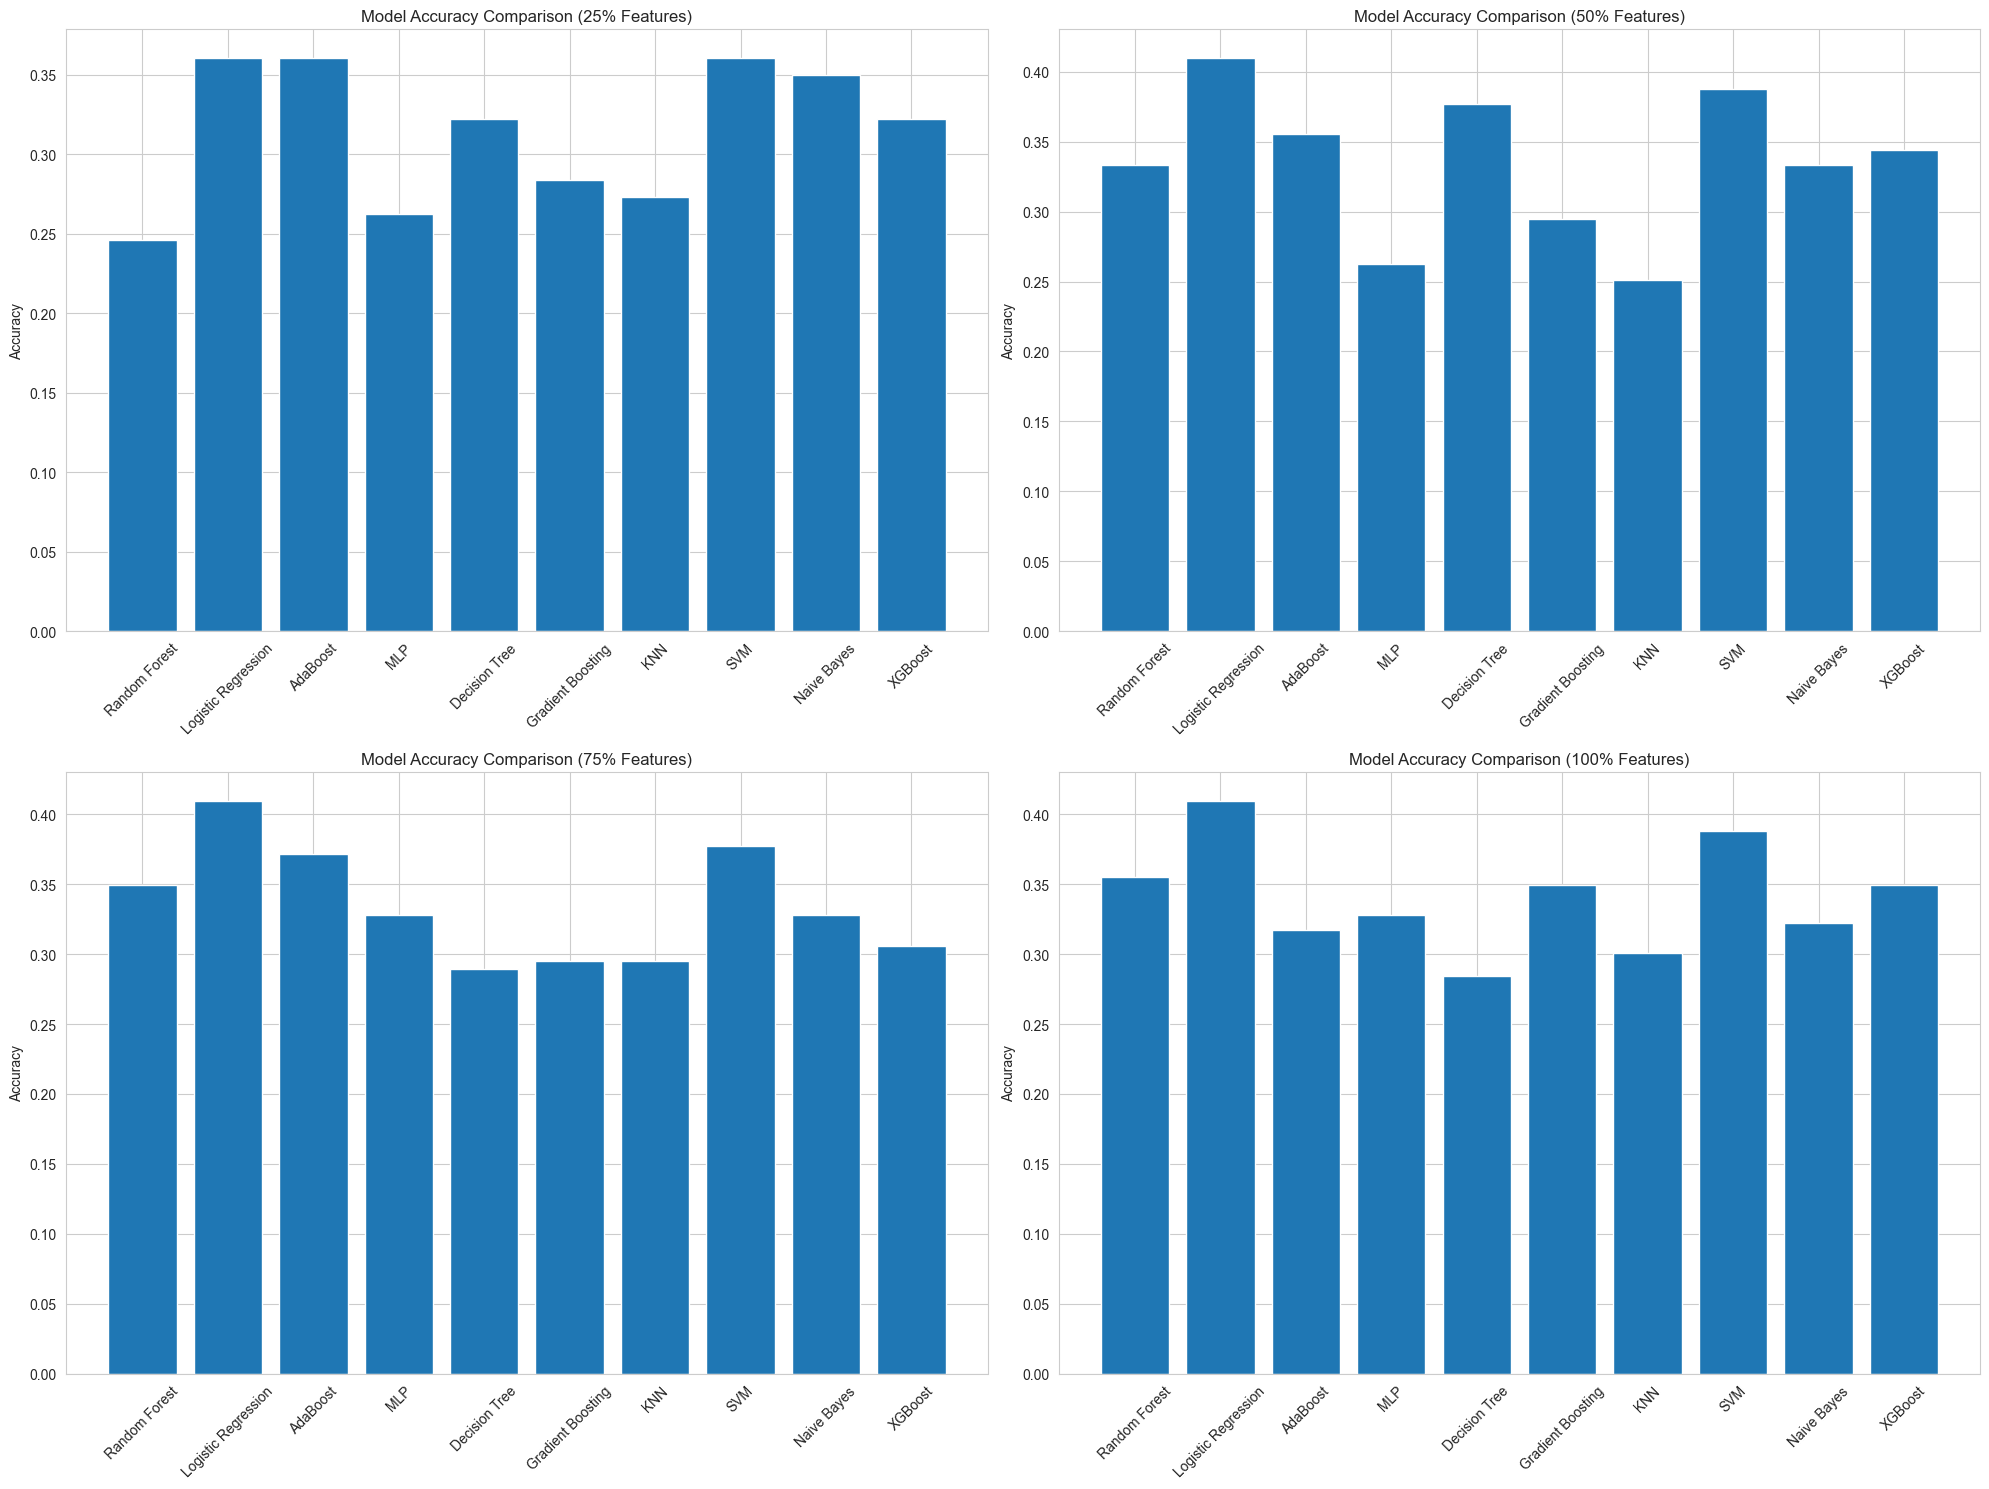

In [68]:
# Assuming df is your DataFrame and 'target' is your target column
X = grouped_master_dataset.drop(columns=['Patient ID', 'Visit Date', 'month_interval', 'Visit_Class', 'EVENT_ID', 'CONCOHORT'])
y = grouped_master_dataset['Visit_Class']

# Standardize features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Transform the target variable
le = LabelEncoder()
y = le.fit_transform(y)

# Define the percentages of features to select
feature_percentages = [0.25, 0.50, 0.75, 1.00]

# List of models
models = {
    "Random Forest": RandomForestClassifier(),
    "Logistic Regression": LogisticRegression(max_iter=10000),
    "AdaBoost": AdaBoostClassifier(algorithm='SAMME'),
    "MLP": MLPClassifier(max_iter=10000),
    "Decision Tree": DecisionTreeClassifier(),
    "Gradient Boosting": GradientBoostingClassifier(),
    "KNN": KNeighborsClassifier(),
    "SVM": SVC(),
    "Naive Bayes": GaussianNB(),
    "XGBoost": XGBClassifier(eval_metric='mlogloss')
}

fig, axs = plt.subplots(2, 2, figsize=(20, 15))

from skfeature.function.similarity_based import fisher_score

for i, percentage in enumerate(feature_percentages):
    # Fisher Score
    scores = fisher_score.fisher_score(X_scaled, y)

    # Sort the feature indices by Fisher Score
    indices = np.argsort(scores)[::-1]

    # Calculate the number of features to select
    n_features_to_select = int(len(indices) * percentage)

    # Select the top N% features
    selected_indices = indices[:n_features_to_select]
    selected_columns = X.columns[selected_indices]
    print(f"Top performing columns for {int(percentage * 100)}% features:")
    print(selected_columns)

    X_selected = X_scaled[:, selected_indices]

    # Split the data
    X_train, X_test, y_train, y_test = train_test_split(X_selected, y, test_size=0.2, random_state=42)

    # Train and evaluate each model
    results = {}
    for name, model in models.items():
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        accuracy = accuracy_score(y_test, y_pred)
        results[name] = accuracy
        print(f"{name} Accuracy with {int(percentage * 100)}% features: {accuracy:.4f}")

    # Plot the results
    ax = axs[i // 2, i % 2]
    ax.bar(results.keys(), results.values())
    ax.set_title(f'Model Accuracy Comparison ({int(percentage * 100)}% Features)')
    ax.set_ylabel('Accuracy')
    ax.set_xticklabels(results.keys(), rotation=45)

plt.tight_layout()
plt.show()